# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
import time
time.sleep(int(60*60*0)) #wait 0h

In [2]:
import math
def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

In [3]:
d = 3  
n = 4
sparsity = nCr(n+d, d)

x_max = 1#10 #this number excluded
x_min = -1#-10
x_step = 0.01#0.1
a_max = 10 #this number excluded
a_min = -10
a_step = 0.1

n_jobs = 1


data_size = 100000 #for loading lambda models

random_evaluation_dataset_size = 500

#lambda net specifications for loading (need to be set according to lambda net training to load correct weights)
epochs_lambda = 200
batch_lambda = 64
lambda_network_layers = [5*sparsity]
optimizer_lambda = '_' + 'adam'


lambda_dataset_size = 1000

#set if multi_epoch_analysis should be performed
multi_epoch_analysis = False
each_epochs_save_lambda = 20
epoch_start = 0 #use to skip first epochs in multi_epoch_analysis

#set if samples analysis should be performed
samples_list = None#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 

evaluate_with_real_function = True
consider_labels_training = False

same_training_all_lambda_nets = False

fixed_seed_lambda_training = False
fixed_initialization_lambda_training = False
number_different_lambda_trainings = 0

inet_holdout_seed_evaluation = False
seed_in_inet_training = False


In [4]:
##############DO NOT CHANGE###################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 
RANDOM_SEED = 42

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

advanced_metric_dataset_size = 10#200

use_gpu = True
if use_gpu:
    gpu_numbers = '1'
else:
    gpu_numbers = ''

if fixed_seed_lambda_training:
    seed_shuffle_string = '_' + str(number_different_lambda_trainings) + '-FixedSeed'
else:
    seed_shuffle_string = '_NoFixedSeed'
    
if fixed_initialization_lambda_training:
    seed_shuffle_string += '_' + str(number_different_lambda_trainings) + '-FixedEvaluation'
else:
    seed_shuffle_string += '_NoFixedEvaluation'

if same_training_all_lambda_nets:
    training_string = '_same'
else:
    training_string = '_diverse'

layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])

structure = '_' + layers_str + str(epochs_lambda) + 'e' + str(batch_lambda) + 'b' + optimizer_lambda
filename = seed_shuffle_string + '_' + str(RANDOM_SEED) + structure

interpretation_network_string = 'custom_structure'


## Imports

In [5]:
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer


import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import Conv1D, Flatten, MaxPooling1D
from autokeras import keras_layers

from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

try:
    # Create target Directory
    os.mkdir('./data/plotting/' + interpretation_network_string + filename + '/')
    os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
except FileExistsError:
    pass

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Math, Latex


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


## Utility functions

In [9]:
#General Utility Functions

ALPHABET = \
  "0123456789abcdefghijklmnopqrstuvwxyz"

def encode (n):
    try:
        return ALPHABET [n]
    except IndexError:
        raise Exception ("cannot encode: %s" % n)
        
def dec_to_base (dec = 0, base = 16):
    if dec < base:
        return encode (dec)
    else:
        return dec_to_base (dec // base, base) + encode (dec % base)

def return_float_tensor_representation(some_representation, dtype=tf.float32):
    if tf.is_tensor(some_representation):
        some_representation = tf.dtypes.cast(some_representation, dtype) 
    else:
        some_representation = tf.convert_to_tensor(some_representation)
        some_representation = tf.dtypes.cast(some_representation, dtype) 
        
    if not tf.is_tensor(some_representation):
        raise SystemExit('Given variable is no instance of ' + str(dtype) + ':' + str(some_representation))
     
    return some_representation


def return_numpy_representation(some_representation):
    if isinstance(some_representation, pd.DataFrame):
        some_representation = some_representation.values
        
    if isinstance(some_representation, list):
        some_representation = np.array(some_representation)
    
    if not isinstance(some_representation, np.ndarray):
        raise SystemExit('Given variable is no instance of ' + str(np.ndarray) + ':' + str(some_representation))
    
    return some_representation

def mergeDict(dict1, dict2):
    #Merge dictionaries and keep values of common keys in list
    newDict = {**dict1, **dict2}
    for key, value in newDict.items():
        if key in dict1 and key in dict2:
            if isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend(value)
            elif isinstance(dict1[key], list) and not isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend([value])
            elif not isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = [dict1[key]]
                newDict[key].extend(value)
            else:
                newDict[key] = [dict1[key], value]
    return newDict

def return_callbacks_from_string(callback_string_list):
    callbacks = [] if len(callback_string_list) > 0 else None
    #if 'plot_losses_callback' in callback_string_list:
        #callbacks.append(PlotLossesCallback())
    if 'reduce_lr_loss' in callback_string_list:
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=epochs/10, verbose=0, min_delta=0, mode='min') #epsilon
        callbacks.append(reduce_lr_loss)
    if 'early_stopping' in callback_string_list:
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0, verbose=0, mode='min')
        callbacks.append(earlyStopping)
        
    #if not multi_epoch_analysis and samples_list == None: 
        #callbacks.append(TQDMNotebookCallback())
        
    return callbacks

def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

def generate_random_x_values(size, x_max, x_min, x_step, numnber_of_variables, seed=42):
    
    if random.seed != None:
        random.seed(seed)
    
    x_values_list = []
    
    for j in range(size):
        values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))
        while arreq_in_list(values, x_values_list):
                values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))         
        x_values_list.append(values)
    
    return np.array(x_values_list)

def flatten(l):
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
            
def print_polynomial_from_coefficients(coefficients):

    global list_of_monomial_identifiers
    
    string = ''
    for identifier, coefficient in zip(list_of_monomial_identifiers, coefficients):
        string += str(np.round(coefficient, 2))
        for index, variable_identifier in enumerate(identifier):  
            if int(variable_identifier) == 1:
                #string += '*'
                string += 'abcdefghijklmnopqrstuvwxyz'[index]
            elif int(variable_identifier) > 1:
                #string += '*'
                string += 'abcdefghijklmnopqrstuvwxyz'[index] + '^' + str(variable_identifier)
    
        string += ' + '
        
    latex_string = "$" + string[:-3] + "$"
    
    return display(Math(latex_string))


In [10]:
class LambdaNetDataset():
    lambda_net_list = None
    
    weight_list = None
    
    train_settings_list = None
    index_list = None
    
    target_polynomial_list = None
    lstsq_lambda_pred_polynomial_list = None
    lstsq_target_polynomial_list = None    
        
    test_data_list = None
    
    def __init__(self, lambda_net_list):
        self.lambda_net_list = lambda_net_list
        
        self.weight_list = [lambda_net.weights for lambda_net in lambda_net_list]
        
        self.train_settings_list = {}
        for key in lambda_net_list[0].train_settings.keys():
            self.train_settings_list[key] = []   
        for lambda_net in lambda_net_list:
            for key in lambda_net.train_settings.keys():
                self.train_settings_list[key].append(lambda_net.train_settings[key])
        
        self.index_list = [lambda_net.index for lambda_net in lambda_net_list]
        
        self.target_polynomial_list = [lambda_net.target_polynomial for lambda_net in lambda_net_list]
        self.lstsq_lambda_pred_polynomial_list = [lambda_net.lstsq_lambda_pred_polynomial for lambda_net in lambda_net_list]
        self.lstsq_target_polynomial_list = [lambda_net.lstsq_target_polynomial for lambda_net in lambda_net_list]
      
        self.test_data_list = [lambda_net.test_data for lambda_net in lambda_net_list]
    
    def __repr__(self):
        return str(self.as_pandas().head())
    def __str__(self):
        return str(self.as_pandas().head())
    
    def __len__(self):
        return len(self.lambda_net_list)
    
    
    def make_prediction_on_dataset(self, evaluation_dataset):  
        assert(evaluation_dataset.shape[1] == n)
        lambda_network_preds_list = []
        
        for weights in self.weight_list:
            lambda_network_preds = weights_to_pred(weights, evaluation_dataset)
            lambda_network_preds_list.append(lambda_network_preds)
        
        return np.array(lambda_network_preds_list)
    
    def make_prediction_on_test_data(self):
        lambda_network_preds_list = []
        for lambda_net in self.lambda_net_list:
            lambda_network_preds = lambda_net.make_prediction_on_test_data()
            lambda_network_preds_list.append(lambda_network_preds)
            
        return np.array(lambda_network_preds_list)
                
        
    def return_target_poly_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape + ' but required (x, ' + str(n) + ')'))     
        target_poly_fvs_list = parallel_fv_calculation_from_polynomial(self.target_polynomial_list, [evaluation_dataset for _ in range(len(self.target_polynomial_list))])
            
        return np.array(target_poly_fvs_list)
    
    def return_target_poly_fvs_on_test_data(self):        
        target_poly_fvs_list = parallel_fv_calculation_from_polynomial(self.target_polynomial_list, self.test_data_list)
        
        return np.array(target_poly_fvs_list)
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape + ' but required (x, ' + str(n) + ')'))    
        lstsq_lambda_pred_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_lambda_pred_polynomial_list, [evaluation_dataset for _ in range(len(self.target_polynomial_list))])
            
        return np.array(lstsq_lambda_pred_polynomial_fvs_list)
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_test_data(self):
        lstsq_lambda_pred_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_lambda_pred_polynomial_list, self.test_data_list)
            
        return np.array(lstsq_lambda_pred_polynomial_fvs_list)
    
    def return_lstsq_target_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape + ' but required (x, ' + str(n) + ')'))
        lstsq_target_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_target_polynomial_list, [evaluation_dataset for _ in range(len(self.target_polynomial_list))])
            
        return np.array(lstsq_target_polynomial_fvs_list)
    
    def return_lstsq_target_polynomial_fvs_on_test_data(self):
        lstsq_target_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_target_polynomial_list, self.test_data_list)
            
        return np.array(lstsq_target_polynomial_fvs_list)
    
    def as_pandas(self):  
        lambda_dataframe = pd.DataFrame(data=[lambda_net.as_array() for lambda_net in self.lambda_net_list], 
                                columns=self.lambda_net_list[0].return_column_names(), 
                                index=[lambda_net.index for lambda_net in self.lambda_net_list])
        lambda_dataframe['seed'] = lambda_dataframe['seed'].astype(int)
        
        return lambda_dataframe

    
    def get_lambda_nets_by_seed(self, seed_list):
        lambda_nets_by_seed = []
        for lambda_net in self.lambda_net_list:
            if lambda_net.train_settings['seed'] in seed_list:
                lambda_nets_by_seed.append(lambda_net)
    
        return LambdaNetDataset(lambda_nets_by_seed)
    
    def get_lambda_nets_by_lambda_index(self, lambda_index_list):
        lambda_nets_by_lambda_index = []
        for lambda_net in self.lambda_net_list:
            if lambda_net.index in lambda_index_list:
                lambda_nets_by_lambda_index.append(lambda_net)
    
        return LambdaNetDataset(lambda_nets_by_lambda_index) 
    
    def get_lambda_net_by_lambda_index(self, lambda_index):
        for lambda_net in self.lambda_net_list:
            if lambda_net.index in lambda_index:
                return lambda_net
    
        return None
    
    def sample(self, size, seed=42):
        
        assert(isinstance(size, int) or isinstance(size, float), 'Wrong sample size specified')
        
        random.seed(seed)
        
        sample_lambda_net_list = None
        if isinstance(size, int):
            sample_lambda_net_list = random.sample(self.lambda_net_list, size)
        elif isinstance(size, float):
            size = int(np.round(len(self.lambda_net_list)*size))
            sample_lambda_net_list = random.sample(self.lambda_net_list, size)
            
        return LambdaNetDataset(sample_lambda_net_list)
    

class LambdaNet():
    weights = None
    model = None
    
    train_settings = None
    index = None
    
    target_polynomial = None
    lstsq_lambda_pred_polynomial = None
    lstsq_target_polynomial = None
    
    test_data = None
    
    def __init__(self, line):
        assert(isinstance(line, np.ndarray), 'line is no array: ' + str(line))
        
        self.index = int(line[0])
        try:
            self.train_settings = {'seed': int(line[1])}
        except ValueError:
            self.train_settings = {'seed': -1}
            
        self.target_polynomial = line[range(2, nCr(n+d, d)+2)].astype(float)
        self.lstsq_lambda_pred_polynomial = line[range(nCr(n+d, d)+2, nCr(n+d, d)*2+2)].astype(float)
        self.lstsq_target_polynomial = line[range(nCr(n+d, d)*2+2, nCr(n+d, d)*3+2)].astype(float)
        assert(self.target_polynomial.shape[0] == sparsity, 'target polynomial has incorrect shape ' + str(self.target_polynomial.shape[0]) + ' but should be ' + str(sparsity))
        assert(self.lstsq_lambda_pred_polynomial.shape[0] == sparsity, 'lstsq lambda pred polynomial has incorrect shape ' + str(self.lstsq_lambda_pred_polynomial.shape[0]) + ' but should be ' + str(sparsity))
        assert(self.lstsq_target_polynomial.shape[0] == sparsity, 'lstsq target polynomial has incorrect shape ' + str(self.lstsq_target_polynomial.shape[0]) + ' but should be ' + str(sparsity))    
        
        self.weights = line[nCr(n+d, d)*3+2:].astype(float)
        assert(self.weights.shape[0] == number_of_lambda_weights, 'weights have incorrect shape ' + str(self.weights.shape[0]) + ' but should be ' + str(number_of_lambda_weights))
        
        directory = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
        path = directory + 'lambda_' + str(self.index) + '_test_data.npy'
        
        self.test_data = np.load(path)
        assert(self.test_data.shape[1] == n, 'test data has wrong shape ' + str(self.test_data.shape) + ' but required (x, ' + str(n) + ')')
        
    def __repr__(self):
        return str(self.weights)
    def __str__(self):
        return str(self.weights)
        
    def make_prediction_on_dataset(self, evaluation_dataset):  
        assert(evaluation_dataset.shape[1] == n) 
        lambda_network_preds = weights_to_pred(self.weights, evaluation_dataset)
        
        return lambda_network_preds
    
    def make_prediction_on_test_data(self):        
        lambda_network_preds = weights_to_pred(self.weights, self.test_data)
        
        return lambda_network_preds               
        
    def return_target_poly_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape) + ' but required (x, ' + str(n) + ')')
        target_poly_fvs = parallel_fv_calculation_from_polynomial([self.target_polynomial], [evaluation_dataset])
    
        return target_poly_fvs
    
    def return_target_poly_fvs_on_test_data(self):
        target_poly_fvs = parallel_fv_calculation_from_polynomial([self.target_polynomial], [self.test_data])
    
        return target_poly_fvs    
    
    
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape) + ' but required (x, ' + str(n) + ')')
        lstsq_lambda_pred_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_lambda_pred_polynomial], [evaluation_dataset])
    
        return lstsq_lambda_pred_polynomial_fvs
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_test_data(self):
        lstsq_lambda_pred_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_lambda_pred_polynomial], [self.test_data])
    
        return lstsq_lambda_pred_polynomial_fvs     
    
    def return_lstsq_target_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape) + ' but required (x, ' + str(n) + ')')
        lstsq_target_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_target_polynomial], [evaluation_dataset])
    
        return lstsq_target_polynomial_fvs
    
    def return_lstsq_target_polynomial_fvs_on_test_data(self):
        lstsq_target_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_target_polynomial], [self.test_data])
    
        return lstsq_target_polynomial_fvs  
    
    def as_pandas(self): 
        columns = return_column_names(self)
        data = as_array(self)
        
        df = pd.DataFrame(data=data, columns=columns, index=[self.index])
        df['seed'] = df['seed'].astype(int)
        
        return df
    
    def as_array(self):
        data = np.hstack([self.train_settings['seed'], self.target_polynomial, self.lstsq_lambda_pred_polynomial, self.lstsq_target_polynomial, self.weights])
        return data
    
    def return_column_names(self):
        target_polynomial_identifiers = [monomial_identifiers + str('-target') for monomial_identifiers in list_of_monomial_identifiers]
        lstsq_lambda_pred_polynomial_identifiers = [monomial_identifiers + str('-lstsq_lambda') for monomial_identifiers in list_of_monomial_identifiers]
        lstsq_target_polynomial_identifiers = [monomial_identifiers + str('-lstsq_target') for monomial_identifiers in list_of_monomial_identifiers]

        weight_identifiers = ['wb_' + str(i) for i in range(self.weights.shape[0])]
        
        columns = list(flatten(['seed', target_polynomial_identifiers, lstsq_lambda_pred_polynomial_identifiers, lstsq_target_polynomial_identifiers, weight_identifiers]))
                
        return columns 

    
    
    
def split_LambdaNetDataset(dataset, test_split, random_seed=RANDOM_SEED):
    assert(isinstance(dataset, LambdaNetDataset))
    
    lambda_nets_list = dataset.lambda_net_list
    
    if isinstance(test_split, int) or isinstance(test_split, float):
        lambda_nets_train_list, lambda_nets_test_list = train_test_split(lambda_nets_list, test_size=test_split, random_state=random_seed)     
    elif isinstance(test_split, list):
        lambda_nets_test_list = [lambda_nets_list[i] for i in test_split]
        lambda_nets_train_list = list(set(lambda_nets_list) - set(lambda_nets_test_list))
        #lambda_nets_train_list = lambda_nets_list.copy()
        #for i in sorted(test_split, reverse=True):
        #    del lambda_nets_train_list[i]           
    assert(len(lambda_nets_list) == len(lambda_nets_train_list) + len(lambda_nets_test_list))
    
    return LambdaNetDataset(lambda_nets_train_list), LambdaNetDataset(lambda_nets_test_list)
                                                                                                 
def generate_base_model(): #without dropout
    base_model = Sequential()

    base_model.add(Dense(lambda_network_layers[0], activation='relu', input_dim=n))

    for neurons in lambda_network_layers[1:]:
        base_model.add(Dense(neurons, activation='relu'))

    base_model.add(Dense(1))
    
    return base_model

def shape_flat_weights(flat_weights, target_weights):
    
    shaped_weights =[]
    start = 0
    for el in target_weights:
        target_shape = el.shape
        size = len(list(flatten(el)))
        shaped_el = np.reshape(flat_weights[start:start+size], target_shape)
        shaped_weights.append(shaped_el)
        start += size

    return shaped_weights

def weights_to_pred(weights, x, base_model=None):

    if base_model is None:
        base_model = generate_base_model()
    else:
        base_model = keras.models.clone_model(base_model)
    
    # Shape weights (flat) into correct model structure
    shaped_weights = shape_flat_weights(weights, base_model.get_weights())
    
    # Make prediction
    base_model.set_weights(shaped_weights)
    y = base_model.predict(x).ravel()
    return y        

### Generate List of Monomial Identifiers

In [11]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/256 [00:00<?, ?it/s]

List length: 256
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0013', '0020', '0021', '0022', '0023', '0030', '0031', '0032', '0033', '0100', '0101', '0102', '0103', '0110', '0111', '0112', '0113', '0120', '0121', '0122', '0123', '0130', '0131', '0132', '0133', '0200', '0201', '0202', '0203', '0210', '0211', '0212', '0213', '0220', '0221', '0222', '0223', '0230', '0231', '0232', '0233', '0300', '0301', '0302', '0303', '0310', '0311', '0312', '0313', '0320', '0321', '0322', '0323', '0330', '0331', '0332', '0333', '1000', '1001', '1002', '1003', '1010', '1011', '1012', '1013', '1020', '1021', '1022', '1023', '1030', '1031', '1032', '1033', '1100', '1101', '1102', '1103', '1110', '1111', '1112', '1113', '1120', '1121', '1122', '1123', '1130', '1131', '1132', '1133', '1200', '1201', '1202', '1203', '1210', '1211', '1212', '1213', '1220', '1221', '1222', '1223', '1230', '1231', '1232', '1233', '13

  0%|          | 0/256 [00:00<?, ?it/s]

List length: 35
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0020', '0021', '0030', '0100', '0101', '0102', '0110', '0111', '0120', '0200', '0201', '0210', '0300', '1000', '1001', '1002', '1010', '1011', '1020', '1100', '1101', '1110', '1200', '2000', '2001', '2010', '2100', '3000']


## Loss/Error functions

In [12]:
#Manual TF Loss function for comparison with lambda-net prediction based (predictions made in loss function)


def mean_absolute_error_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers, base_model):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)    
    
    model_lambda_placeholder = keras.models.clone_model(base_model)  
    
    weights_structure = base_model.get_weights()
    dims = [np_arrays.shape for np_arrays in weights_structure]
    
    def mean_absolute_error_tf_fv_lambda_extended(polynomial_true_with_lambda_fv, polynomial_pred):

        if seed_in_inet_training:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity+1:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
        else:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
            
        network_parameters = return_float_tensor_representation(network_parameters)
        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity)
        assert(polynomial_pred.shape[1] == sparsity)   
        assert(network_parameters.shape[1] == number_of_lambda_weights)   
        
        return tf.math.reduce_mean(tf.map_fn(calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder), (polynomial_pred, network_parameters), fn_output_signature=tf.float32))
    return mean_absolute_error_tf_fv_lambda_extended

def calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder):

    def calculate_mae_fv_lambda(input_list):

        #single polynomials
        #polynomial_true = input_list[0]
        polynomial_pred = input_list[0]
        network_parameters = input_list[1]
        
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))

        #CALCULATE LAMBDA FV HERE FOR EVALUATION DATASET
        # build models
        start = 0
        layers = []
        for i in range(len(dims)//2):
            
            # set weights of layer
            index = i*2
            size = np.product(dims[index])
            weights_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[0].assign(weights_tf_true)
            start += size
            
            # set biases of layer
            index += 1
            size = np.product(dims[index])
            biases_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[1].assign(biases_tf_true)
            start += size

        
        lambda_fv = tf.keras.backend.flatten(model_lambda_placeholder(evaluation_dataset))
        
        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (lambda_fv, polynomial_pred_fv_list)))
    
    return calculate_mae_fv_lambda



#Manual TF Loss function for fv comparison of real and predicted polynomial

def mean_absolute_error_tf_fv_poly_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)        
    
    def mean_absolute_error_tf_fv_poly_extended(polynomial_true, polynomial_pred):

        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_true.shape))
        assert(polynomial_pred.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_pred.shape))       
        
        return tf.math.reduce_mean(tf.map_fn(calculate_mae_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers), (polynomial_true, polynomial_pred), fn_output_signature=tf.float32))
    return mean_absolute_error_tf_fv_poly_extended

def calculate_mae_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers):

    def calculate_mae_fv_poly(input_list):

        #single polynomials
        polynomial_true = input_list[0]
        polynomial_pred = input_list[1]
        
        polynomial_true_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_true), (evaluation_dataset))
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))
        
        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (polynomial_true_fv_list, polynomial_pred_fv_list)))
    
    return calculate_mae_fv_poly





#GENERAL LOSS UTILITY FUNCTIONS
def calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred):


    def calculate_fv_from_data(evaluation_entry):


        value_without_coefficient = tf.vectorized_map(calculate_value_without_coefficient_wrapper(evaluation_entry), (list_of_monomial_identifiers))
        polynomial_pred_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_pred))
        
        polynomial_pred_fv = tf.reduce_sum(polynomial_pred_value_per_term)     
        
        return polynomial_pred_fv
    return calculate_fv_from_data


#calculate intermediate term (without coefficient multiplication)
def calculate_value_without_coefficient_wrapper(evaluation_entry):
    def calculate_value_without_coefficient(coefficient_multiplier_term):      
   
        return tf.math.reduce_prod(tf.vectorized_map(lambda x: x[0]**x[1], (evaluation_entry, coefficient_multiplier_term)))
    return calculate_value_without_coefficient

#calculate MAE at the end ---> general:REPLACE FUNCTION WITH LOSS CALL OR LAMBDA
def calculate_mae_single_input(input_list):
    true_fv = input_list[0]
    pred_fv = input_list[1]

    return tf.math.abs(tf.math.subtract(true_fv, pred_fv))




#BASIC COEFFICIENT-BASED LOSS IF X_DATA IS APPENDED
def mean_absolute_error_extended(polynomial_true_with_lambda_fv, polynomial_pred): 
    
    if seed_in_inet_training:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights+1)
    else:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights)
    
    polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]    
    
    assert(polynomial_true.shape[1] == sparsity)
    assert(polynomial_pred.shape[1] == sparsity)
    
    return tf.keras.losses.MAE(polynomial_true, polynomial_pred)


In [13]:
def r2_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers, base_model):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)    
    
    model_lambda_placeholder = keras.models.clone_model(base_model)  
    
    weights_structure = base_model.get_weights()
    dims = [np_arrays.shape for np_arrays in weights_structure]
    
    def r2_tf_fv_lambda_extended(polynomial_true_with_lambda_fv, polynomial_pred):

        if seed_in_inet_training:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity+1:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
        else:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
            
        network_parameters = return_float_tensor_representation(network_parameters)
        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity)
        assert(polynomial_pred.shape[1] == sparsity)   
        assert(network_parameters.shape[1] == number_of_lambda_weights)   
        
        return tf.math.reduce_mean(tf.map_fn(calculate_r2_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder), (polynomial_pred, network_parameters), fn_output_signature=tf.float32))
    return r2_tf_fv_lambda_extended

def calculate_r2_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder):

    def calculate_r2_fv_lambda(input_list):

        #single polynomials
        #polynomial_true = input_list[0]
        polynomial_pred = input_list[0]
        network_parameters = input_list[1]
        
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))

        #CALCULATE LAMBDA FV HERE FOR EVALUATION DATASET
        # build models
        start = 0
        layers = []
        for i in range(len(dims)//2):
            
            # set weights of layer
            index = i*2
            size = np.product(dims[index])
            weights_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[0].assign(weights_tf_true)
            start += size
            
            # set biases of layer
            index += 1
            size = np.product(dims[index])
            biases_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[1].assign(biases_tf_true)
            start += size

        
        lambda_fv = tf.keras.backend.flatten(model_lambda_placeholder(evaluation_dataset))
        
        return r2_keras_loss(lambda_fv, polynomial_pred_fv_list)
    
    return calculate_r2_fv_lambda



#Manual TF Loss function for fv comparison of real and predicted polynomial

def r2_tf_fv_poly_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)        
    
    @tf.function()
    def r2_tf_fv_poly_extended(polynomial_true, polynomial_pred):

        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_true.shape))
        assert(polynomial_pred.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_pred.shape))       
        
        return tf.math.reduce_mean(tf.map_fn(calculate_r2_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers), (polynomial_true, polynomial_pred), fn_output_signature=tf.float32))
    return r2_tf_fv_poly_extended

def calculate_r2_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers):

    def calculate_r2_fv_poly(input_list):

        #single polynomials
        polynomial_true = input_list[0]
        polynomial_pred = input_list[1]
        
        polynomial_true_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_true), (evaluation_dataset))
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))
        
        return r2_keras_loss(polynomial_true_fv_list, polynomial_pred_fv_list)
    
    return calculate_r2_fv_poly



#calculate MAE at the end ---> general:REPLACE FUNCTION WITH LOSS CALL OR LAMBDA
def calculate_r2_single_input(input_list):
    true_fv = input_list[0]
    pred_fv = input_list[1]

    return r2_keras(true_fv, pred_fv)




#BASIC COEFFICIENT-BASED LOSS IF X_DATA IS APPENDED
def r2_extended(polynomial_true_with_lambda_fv, polynomial_pred): 
    
    if seed_in_inet_training:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights+1)
    else:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights)
    
    polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]    
    
    assert(polynomial_true.shape[1] == sparsity)
    assert(polynomial_pred.shape[1] == sparsity)
    
    return r2_keras(polynomial_true, polynomial_pred)

def r2_keras(y_true, y_pred, epsilon=K.epsilon()):
    
    y_true_cleared = tf.boolean_mask(y_true, tf.not_equal(return_float_tensor_representation(0), y_true))
    y_pred_cleared = tf.boolean_mask(y_pred, tf.not_equal(return_float_tensor_representation(0), y_true))

    epsilon = 1e-5
    SS_res =  K.sum(K.square(y_true_cleared - y_pred_cleared)) 
    SS_tot = K.sum(K.square(y_true_cleared - K.mean(y_true_cleared))) 
    return ( 1 - SS_res/(SS_tot + epsilon) )

def r2_keras_loss(y_true, y_pred, epsilon=K.epsilon()):
    
    #y_true = tf.boolean_mask(y_true, tf.not_equal(return_float_tensor_representation(0), y_true))
    #y_pred = tf.boolean_mask(y_pred, tf.not_equal(return_float_tensor_representation(0), y_true))

    #epsilon = 1e-5
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return  - ( 1 - SS_res/(SS_tot + epsilon) )

In [14]:
#Basic Keras/TF Loss functions
def root_mean_squared_error(y_true, y_pred):   
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
        
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)           
            
    return tf.math.sqrt(K.mean(K.square(y_pred - y_true))) 

def accuracy_multilabel(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))      
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(tf.reduce_all(K.equal(y_true, y_pred), axis=1), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def accuracy_single(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))
        
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(K.equal(y_true, y_pred), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def mean_absolute_percentage_error_keras(y_true, y_pred, epsilon=10e-3): 
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)        
    epsilon = return_float_tensor_representation(epsilon)
        
    return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + epsilon))))

def huber_loss_delta_set(y_true, y_pred):
    return keras.losses.huber_loss(y_true, y_pred, delta=0.3)

In [15]:
#Manual calculations for comparison of polynomials based on function values (no TF!)

def calcualate_function_value(coefficient_list, lambda_input_entry):
    
    global list_of_monomial_identifiers
    
    result = 0   
        
    for coefficient_value, coefficient_multipliers in zip(coefficient_list, list_of_monomial_identifiers):
        value_without_coefficient = [lambda_input_value**int(coefficient_multiplier) for coefficient_multiplier, lambda_input_value in zip(coefficient_multipliers, lambda_input_entry)]

        result += coefficient_value * reduce(lambda x, y: x*y, value_without_coefficient)

    return result

def calculate_function_values_from_polynomial(polynomial, lambda_input_data):        
    function_value_list = []
        
    for lambda_input_entry in lambda_input_data:
        function_value = calcualate_function_value(polynomial, lambda_input_entry)
        function_value_list.append(function_value)

    return np.array(function_value_list)


def parallel_fv_calculation_from_polynomial(polynomial_list, lambda_input_list):
    
    polynomial_list = return_numpy_representation(polynomial_list)
    lambda_input_list = return_numpy_representation(lambda_input_list)
    
    assert(polynomial_list.shape[0] == lambda_input_list.shape[0])
    assert(polynomial_list.shape[1] == sparsity)
    assert(lambda_input_list.shape[2] == n)
    
    n_jobs_parallel_fv = 10 if polynomial_list.shape[0] > 10 else polynomial_list.shape[0]
    
    parallel = Parallel(n_jobs=n_jobs_parallel_fv, verbose=0, backend='threading')
    polynomial_true_fv = parallel(delayed(calculate_function_values_from_polynomial)(polynomial, lambda_inputs) for polynomial, lambda_inputs in zip(polynomial_list, lambda_input_list))  
    del parallel   
    

    return np.array(polynomial_true_fv)



In [16]:
#Standard Metrics (no TF!)

def mean_absolute_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
    
    return np.mean(np.array(result_list))  

def mean_absolute_error_function_values_return_multi_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
    
    return np.array(result_list) 

def mean_std_function_values_difference(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.std(true_values-pred_values))
    
    return np.mean(np.array(result_list))  

def root_mean_squared_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)         
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sqrt(np.mean((true_values-pred_values)**2)))
    
    return np.mean(np.array(result_list)) 

def mean_absolute_percentage_error_function_values(y_true, y_pred, epsilon=10e-3):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred) 
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(((true_values-pred_values)/(true_values+epsilon)))))

    return np.mean(np.array(result_list))

def r2_score_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
    
    return np.mean(np.array(result_list))

def r2_score_function_values_return_multi_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
    
    return np.array(result_list)

def relative_absolute_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sum(np.abs(true_values-pred_values))/(true_values.shape[0]*np.std(true_values)))
    
    return np.mean(np.array(result_list))

def relative_maximum_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.max(true_values-pred_values)/np.std(true_values))
    
    return np.mean(np.array(result_list))

def mean_area_between_two_curves_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
      
    assert(number_of_variables==1)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(area_between_two_curves(true_values, pred_values))
 
    return np.mean(np.array(result_list))

def mean_dtw_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)

    result_list_single = []
    result_list_array = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_single_value, result_single_array = dtw(true_values, pred_values)
        result_list_single.append(result_single_value)
        result_list_array.append(result_single_array)
    
    return np.mean(np.array(result_list_single)), np.mean(np.array(result_list_array), axis=1)

def mean_frechet_dist_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(frechet_dist(true_values, pred_values))
    
    return np.mean(np.array(result_list))


In [17]:
def evaluate_interpretation_net(y_data_real, 
                                y_data_pred, 
                                polynomial_true_fv, 
                                polynomial_pred_inet_fv):
    
    if type(y_data_real) != type(None) and type(y_data_pred) != type(None):
        y_data_real = return_numpy_representation(y_data_real)
        y_data_pred = return_numpy_representation(y_data_pred)     
        
        assert(y_data_real.shape[1] == sparsity)
        assert(y_data_pred.shape[1] == sparsity)
        
        assert(y_data_real.shape == y_data_pred.shape)
        
        mae_coeff = np.round(mean_absolute_error(y_data_real, y_data_pred), 4)
        rmse_coeff = np.round(root_mean_squared_error(y_data_real, y_data_pred), 4)
        mape_coeff = np.round(mean_absolute_percentage_error_keras(y_data_real, y_data_pred), 4)
        accuracy_coeff = np.round(accuracy_single(y_data_real, y_data_pred), 4)
        accuracy_multi_coeff = np.round(accuracy_multilabel(y_data_real, y_data_pred), 4)
    else:
        mae_coeff = np.nan
        rmse_coeff = np.nan
        mape_coeff = np.nan
        accuracy_coeff = np.nan
        accuracy_multi_coeff = np.nan
        
    polynomial_true_fv = return_numpy_representation(polynomial_true_fv)
    polynomial_pred_inet_fv = return_numpy_representation(polynomial_pred_inet_fv)
    
    assert(polynomial_true_fv.shape == polynomial_pred_inet_fv.shape)
        
    mae_fv = np.round(mean_absolute_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmse_fv = np.round(root_mean_squared_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    mape_fv = np.round(mean_absolute_percentage_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    r2_fv = np.round(r2_score_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    raae_fv = np.round(relative_absolute_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmae_fv = np.round(relative_maximum_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4) 
    
    std_fv_diff = np.round(mean_std_function_values_difference(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    mean_fv_1 = np.mean(polynomial_true_fv)
    mean_fv_2 = np.mean(polynomial_pred_inet_fv)
    std_fv_1 = np.std(polynomial_true_fv)
    std_fv_2 = np.std(polynomial_pred_inet_fv)

    mae_distribution = mean_absolute_error_function_values_return_multi_values(polynomial_true_fv, polynomial_pred_inet_fv)
    r2_distribution = r2_score_function_values_return_multi_values(polynomial_true_fv, polynomial_pred_inet_fv)

    return pd.Series(data=[mae_coeff,
                          rmse_coeff,
                          mape_coeff,
                          accuracy_coeff,
                          accuracy_multi_coeff,
                          
                          mae_fv,
                          rmse_fv,
                          mape_fv,
                          r2_fv,
                          raae_fv,
                          rmae_fv,
                          
                          std_fv_diff,
                           
                          mean_fv_1,
                          mean_fv_2,
                          std_fv_1,
                          std_fv_2],
                     index=['MAE',
                           'RMSE',
                           'MAPE',
                           'Accuracy',
                           'Accuracy Multilabel',
                           
                           'MAE FV',
                           'RMSE FV',
                           'MAPE FV',
                           'R2 FV',
                           'RAAE FV',
                           'RMAE FV',
                            
                           'MEAN STD FV DIFF',
                           'MEAN FV1',
                           'MEAN FV2',
                           'STD FV1',
                           'STD FV2']), {'MAE': pd.Series(data=mae_distribution, 
                                                  index=['L-' + str(i) for i in range(polynomial_true_fv.shape[0])]),
                                        'R2': pd.Series(data=r2_distribution, 
                                                  index=['L-' + str(i) for i in range(polynomial_true_fv.shape[0])])}

## Load Data and Generate Datasets

In [18]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + foldername + 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(index).zfill(3) + filename + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)

    
    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
      
    if data_size < len(lambda_nets):
        random.seed(RANDOM_SEED)
        lambda_nets = random.sample(lambda_nets, data_size)
    
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [19]:
#LOAD DATA
foldername = 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 67.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 67.9min finished


## Data Inspection

In [20]:
lambda_net_dataset.as_pandas().head()


,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

In [21]:
lambda_net_dataset.as_pandas().describe()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

## Generate Datasets for Interpretation-Net training

In [22]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [23]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(81000, 1157)

In [24]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(9000, 1157)

In [25]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(10000, 1157)

In [26]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

In [27]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

In [28]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

## Interpretation Network Training

In [29]:
np.array(lambda_net_valid_dataset_list[-1].test_data_list)[0]

array([[ 0.52, -0.05, -0.22,  0.2 ],
       [ 0.8 , -0.26, -0.58,  0.  ],
       [ 0.57,  0.72, -0.5 ,  0.52],
       [ 0.92,  0.98,  0.26, -0.4 ],
       [-0.12,  0.04, -0.28,  0.94],
       [-0.48, -0.42,  0.71,  0.52],
       [ 0.08, -0.02, -0.77,  0.59],
       [-0.92, -0.71, -0.86, -0.55],
       [ 0.38,  0.98, -0.11, -0.02],
       [ 0.7 , -0.97,  0.52,  0.17],
       [ 0.71,  0.38, -0.33, -0.36],
       [ 0.78, -0.35,  0.38, -0.01],
       [ 0.23,  0.87, -0.94, -0.57],
       [-0.28,  0.72,  0.  , -0.32],
       [ 0.5 , -0.87, -0.48, -0.13],
       [-0.92, -0.11,  0.4 ,  0.63],
       [-0.95, -0.54,  0.59, -0.83],
       [-0.72,  0.95,  0.57, -0.37],
       [-0.22,  0.61, -0.27,  0.54],
       [ 0.47, -0.11, -0.56, -0.09],
       [ 0.7 , -0.76,  0.24, -0.92],
       [-0.66, -0.82,  0.93, -1.  ],
       [-0.69,  0.65, -0.49,  0.31],
       [-0.17,  0.08, -0.61,  0.69],
       [ 0.64, -0.89,  0.57,  0.7 ],
       [-0.8 ,  0.08, -0.09,  0.2 ],
       [ 0.68, -0.03, -0.42, -0.35],
 

In [30]:
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

In [31]:
def train_nn_and_pred(lambda_net_train_dataset,
                      lambda_net_valid_dataset,
                      lambda_net_test_dataset, 
                      callback_names=[], 
                      return_model=False):       
   
    global optimizer

    ############################## DATA PREPARATION ###############################

    if seed_in_inet_training:
        normalizer = Normalizer().fit([np.array(lambda_net_train_dataset.train_settings_list['seed'])])
        train_seed_list = normalizer.transform([np.array(lambda_net_train_dataset.train_settings_list['seed'])])[0]
        valid_seed_list = normalizer.transform([np.array(lambda_net_valid_dataset.train_settings_list['seed'])])[0]
        test_seed_list = normalizer.transform([np.array(lambda_net_test_dataset.train_settings_list['seed'])])[0]

        X_train = np.hstack([np.expand_dims(train_seed_list, axis=1), np.array(lambda_net_train_dataset.weight_list)])
        X_valid = np.hstack([np.expand_dims(valid_seed_list, axis=1), np.array(lambda_net_valid_dataset.weight_list)])
        X_test = np.hstack([np.expand_dims(test_seed_list, axis=1), np.array(lambda_net_test_dataset.weight_list)])
    else:   #normalize if included in training   
        X_train = np.array(lambda_net_train_dataset.weight_list)
        X_valid = np.array(lambda_net_valid_dataset.weight_list)
        X_test = np.array(lambda_net_test_dataset.weight_list) 
        
    if evaluate_with_real_function: #target polynomial as inet target
        y_train = np.array(lambda_net_train_dataset.target_polynomial_list)
        y_valid = np.array(lambda_net_valid_dataset.target_polynomial_list)
        y_test = np.array(lambda_net_test_dataset.target_polynomial_list)
    else: #lstsq lambda pred polynomial as inet target
        y_train = np.array(lambda_net_train_dataset.lstsq_lambda_pred_polynomial_list)
        y_valid = np.array(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list)
        y_test = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)
        
        
        
    base_model = generate_base_model()
    if seed_in_inet_training:
        pass
    else:
        shaped_weights_train_list = []
        for train_data in tqdm(X_train):
            shaped_weights_train = shape_flat_weights(train_data, base_model.get_weights())
            shaped_weights_train_list.append(shaped_weights_train)
            
        max_size = 0
        for weights in shaped_weights_train:
            max_size = max(max_size, max(weights.shape))      
    
        shaped_weights_valid_list = []
        for valid_data in tqdm(X_valid):
            shaped_weights_valid = shape_flat_weights(valid_data, base_model.get_weights())
            shaped_weights_valid_list.append(shaped_weights_valid)
          
        shaped_weights_test_list = []
        for test_data in tqdm(X_test):
            shaped_weights_test = shape_flat_weights(test_data, base_model.get_weights())
            shaped_weights_test_list.append(shaped_weights_test)
         
        if False: #one sequence for biases and one sequence for weights per layer (padded to maximum size)
            X_train_list = []
            for shaped_weights_train in tqdm(shaped_weights_train_list):
                padded_network_parameters_train_list = []
                for layer_weights, biases in pairwise(shaped_weights_train):
                    padded_weights_train_list = []
                    for weights in layer_weights:
                        padded_weights_train = np.pad(weights, (int(np.floor((max_size-weights.shape[0])/2)), int(np.ceil((max_size-weights.shape[0])/2))), 'constant')
                        padded_weights_train_list.append(padded_weights_train)
                    padded_biases_train = np.pad(biases, (int(np.floor((max_size-biases.shape[0])/2)), int(np.ceil((max_size-biases.shape[0])/2))), 'constant')
                    padded_network_parameters_train_list.append(padded_biases_train)
                    padded_network_parameters_train_list.extend(padded_weights_train_list)   
                X_train_list.append(padded_network_parameters_train_list)
            X_train = np.array(X_train_list)    


            X_valid_list = []
            for shaped_weights_train in tqdm(shaped_weights_valid_list):
                padded_network_parameters_valid_list = []
                for layer_weights, biases in pairwise(shaped_weights_valid):
                    padded_weights_valid_list = []
                    for weights in layer_weights:
                        padded_weights_valid = np.pad(weights, (int(np.floor((max_size-weights.shape[0])/2)), int(np.ceil((max_size-weights.shape[0])/2))), 'constant')
                        padded_weights_valid_list.append(padded_weights_valid)
                    padded_biases_valid = np.pad(biases, (int(np.floor((max_size-biases.shape[0])/2)), int(np.ceil((max_size-biases.shape[0])/2))), 'constant')
                    padded_network_parameters_valid_list.append(padded_biases_valid)
                    padded_network_parameters_valid_list.extend(padded_weights_valid_list)    
                X_valid_list.append(padded_network_parameters_valid_list)
            X_valid = np.array(X_valid_list) 

            X_test_list = []
            for shaped_weights_train in tqdm(shaped_weights_test_list):        
                padded_network_parameters_test_list = []
                for layer_weights, biases in pairwise(shaped_weights_test):
                    padded_weights_test_list = []
                    for weights in layer_weights:
                        padded_weights_test = np.pad(weights, (int(np.floor((max_size-weights.shape[0])/2)), int(np.ceil((max_size-weights.shape[0])/2))), 'constant')
                        padded_weights_test_list.append(padded_weights_test)
                    padded_biases_test = np.pad(biases, (int(np.floor((max_size-biases.shape[0])/2)), int(np.ceil((max_size-biases.shape[0])/2))), 'constant')
                    padded_network_parameters_test_list.append(padded_biases_test)
                    padded_network_parameters_test_list.extend(padded_weights_test_list)    
                X_test_list.append(padded_network_parameters_test_list)
            X_test = np.array(X_test_list)   
        elif True: #each path from input bias to output bias combines in one sequence for biases and one sequence for weights per layer
            lambda_net_structure = list(flatten([n, lambda_network_layers, 1]))                    
            number_of_paths = reduce(lambda x, y: x * y, lambda_net_structure)
                        
            X_train_list = []
            for shaped_weights in tqdm(shaped_weights_train_list):        
                network_parameters_sequence_list = np.array([]).reshape(number_of_paths, 0)    
                for layer_index, (weights, biases) in zip(range(1, len(lambda_net_structure)), pairwise(shaped_weights)):

                    layer_neurons = lambda_net_structure[layer_index]    
                    previous_layer_neurons = lambda_net_structure[layer_index-1]

                    assert(biases.shape[0] == layer_neurons)
                    assert(weights.shape[0]*weights.shape[1] == previous_layer_neurons*layer_neurons)

                    bias_multiplier = number_of_paths//layer_neurons
                    weight_multiplier = number_of_paths//(previous_layer_neurons * layer_neurons)

                    extended_bias_list = []
                    for bias in biases:
                        extended_bias = np.tile(bias, (bias_multiplier,1))
                        extended_bias_list.extend(extended_bias)


                    extended_weights_list = []
                    for weight in weights.flatten():
                        extended_weights = np.tile(weight, (weight_multiplier,1))
                        extended_weights_list.extend(extended_weights)      

                    network_parameters_sequence = np.concatenate([extended_weights_list, extended_bias_list], axis=1)
                    network_parameters_sequence_list = np.hstack([network_parameters_sequence_list, network_parameters_sequence])


                number_of_paths = network_parameters_sequence_list.shape[0]
                number_of_unique_paths = np.unique(network_parameters_sequence_list, axis=0).shape[0]
                number_of_nonUnique_paths = number_of_paths-number_of_unique_paths
                
                if number_of_nonUnique_paths > 0:
                    print("Number of non-unique rows: " + str(number_of_nonUnique_paths))
                    print(network_parameters_sequence_list)
                    
                X_train_list.append(network_parameters_sequence_list)
            X_train = np.array(X_train_list)

            X_valid_list = []
            for shaped_weights in tqdm(shaped_weights_valid_list):        
                network_parameters_sequence_list = np.array([]).reshape(number_of_paths, 0)    
                for layer_index, (weights, biases) in zip(range(1, len(lambda_net_structure)), pairwise(shaped_weights)):

                    layer_neurons = lambda_net_structure[layer_index]    
                    previous_layer_neurons = lambda_net_structure[layer_index-1]

                    assert(biases.shape[0] == layer_neurons)
                    assert(weights.shape[0]*weights.shape[1] == previous_layer_neurons*layer_neurons)

                    bias_multiplier = number_of_paths//layer_neurons
                    weight_multiplier = number_of_paths//(previous_layer_neurons * layer_neurons)

                    extended_bias_list = []
                    for bias in biases:
                        extended_bias = np.tile(bias, (bias_multiplier,1))
                        extended_bias_list.extend(extended_bias)


                    extended_weights_list = []
                    for weight in weights.flatten():
                        extended_weights = np.tile(weight, (weight_multiplier,1))
                        extended_weights_list.extend(extended_weights)      

                    network_parameters_sequence = np.concatenate([extended_weights_list, extended_bias_list], axis=1)
                    network_parameters_sequence_list = np.hstack([network_parameters_sequence_list, network_parameters_sequence])


                number_of_paths = network_parameters_sequence_list.shape[0]
                number_of_unique_paths = np.unique(network_parameters_sequence_list, axis=0).shape[0]
                number_of_nonUnique_paths = number_of_paths-number_of_unique_paths
                
                if number_of_nonUnique_paths > 0:
                    print("Number of non-unique rows: " + str(number_of_nonUnique_paths))
                    print(network_parameters_sequence_list)
                    
                X_valid_list.append(network_parameters_sequence_list)
            X_valid = np.array(X_valid_list)
            
            X_test_list = []
            for shaped_weights in tqdm(shaped_weights_test_list):        
                network_parameters_sequence_list = np.array([]).reshape(number_of_paths, 0)   
                for layer_index, (weights, biases) in zip(range(1, len(lambda_net_structure)), pairwise(shaped_weights)):

                    layer_neurons = lambda_net_structure[layer_index]    
                    previous_layer_neurons = lambda_net_structure[layer_index-1]

                    assert(biases.shape[0] == layer_neurons)
                    assert(weights.shape[0]*weights.shape[1] == previous_layer_neurons*layer_neurons)

                    bias_multiplier = number_of_paths//layer_neurons
                    weight_multiplier = number_of_paths//(previous_layer_neurons * layer_neurons)

                    extended_bias_list = []
                    for bias in biases:
                        extended_bias = np.tile(bias, (bias_multiplier,1))
                        extended_bias_list.extend(extended_bias)


                    extended_weights_list = []
                    for weight in weights.flatten():
                        extended_weights = np.tile(weight, (weight_multiplier,1))
                        extended_weights_list.extend(extended_weights)      

                    network_parameters_sequence = np.concatenate([extended_weights_list, extended_bias_list], axis=1)
                    network_parameters_sequence_list = np.hstack([network_parameters_sequence_list, network_parameters_sequence])


                number_of_paths = network_parameters_sequence_list.shape[0]
                number_of_unique_paths = np.unique(network_parameters_sequence_list, axis=0).shape[0]
                number_of_nonUnique_paths = number_of_paths-number_of_unique_paths
                
                if number_of_nonUnique_paths > 0:
                    print("Number of non-unique rows: " + str(number_of_nonUnique_paths))
                    print(network_parameters_sequence_list)
                    
                X_test_list.append(network_parameters_sequence_list)
            X_test = np.array(X_test_list)
            
            if False:
                X_train = np.transpose(X_train, (0, 2, 1))
                X_valid = np.transpose(X_valid, (0, 2, 1))
                X_test = np.transpose(X_test, (0, 2, 1))    
                
            if False: #generate subsequences for cnn-lstm
                subsequences = 2 #for each bias+weights
                timesteps = X_train.shape[1]//subsequences
                
                X_train = X_train.reshape((X_train.shape[0], subsequences, timesteps, X_train.shape[2]))
                
                X_valid = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, X_valid.shape[2]))

                X_test = X_test.reshape((X_test.shape[0], subsequences, timesteps, X_test.shape[2]))            
        
        
    ############################## OBJECTIVE SPECIFICATION AND LOSS FUNCTION ADJUSTMENTS ###############################
        
    if consider_labels_training: #coefficient-based evaluation
        loss_function = r2_tf_fv
        metrics = [mean_absolute_error_tf_fv, 'mean_absolute_error']
        #loss_function = mean_absolute_error_tf_fv
        #metrics = [r2_tf_fv, 'mean_absolute_error']
        valid_data = (X_valid, y_valid)
        y_train_model = y_train
    else: #fv-based evaluation
        if evaluate_with_real_function: #based on in-loss fv calculation of real and predicted polynomial
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = r2_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)
            metrics = [mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers), 'mean_absolute_error']
            #loss_function = mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)
            #metrics = [r2_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers), 'mean_absolute_error']
            valid_data = (X_valid, y_valid)
            y_train_model = y_train
        else: #in-loss prediction of lambda-nets
            base_model = generate_base_model()
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = r2_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      
            metrics = [mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model), mean_absolute_error_extended]
            #loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      
            #metrics = [r2_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model), mean_absolute_error_extended]
            y_train_model = np.hstack((y_train, X_train))   
            valid_data = (X_valid, np.hstack((y_valid, X_valid)))   
            
        
    if consider_labels_training: #coefficient-based evaluation
        if evaluate_with_real_function: #based on in-metric fv calculation of real and predicted polynomial
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = r2_tf_fv
            #loss_function = 'mean_absolute_error'
            metrics = ['mean_absolute_error', mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)]
            #metrics = [r2_tf_fv, mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)]
            valid_data = (X_valid, y_valid)
            y_train_model = y_train
        else: #in-metric prediction of lambda-nets
            base_model = generate_base_model()
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = r2_extended       
            #loss_function = mean_absolute_error_extended       
            metrics = [mean_absolute_error_extended, mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)]
            #metrics = [r2_extended, mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)]    
            y_train_model = np.hstack((y_train, X_train))   
            valid_data = (X_valid, np.hstack((y_valid, X_valid)))   
    else: #fv-based evaluation
        if evaluate_with_real_function: #based on in-loss fv calculation of real and predicted polynomial
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = r2_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)
            metrics = [mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers), 'mean_absolute_error']
            #loss_function = mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)
            #metrics = [r2_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers), 'mean_absolute_error']
            valid_data = (X_valid, y_valid)
            y_train_model = y_train
        else: #in-loss prediction of lambda-nets
            base_model = generate_base_model()
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = r2_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      
            metrics = [mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model), mean_absolute_error_extended]
            #loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      
            #metrics = [r2_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model), mean_absolute_error_extended]
            y_train_model = np.hstack((y_train, X_train))   
            valid_data = (X_valid, np.hstack((y_valid, X_valid)))   
            
        
    ############################## BUILD MODEL ###############################
        
    model = Sequential()     
    
    model.add(Conv1D(filters=32, kernel_size=(5,), strides=(1,), activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=(5,), strides=(1,), activation='relu'))
    model.add(MaxPooling1D(pool_size=(4,), strides=(4,)))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters=64, kernel_size=(5,), strides=(1,), activation='relu'))
    model.add(Conv1D(filters=32, kernel_size=(5,), strides=(1,), activation='relu'))
    model.add(MaxPooling1D(pool_size=(4,), strides=(4,)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())    
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1024, activation='relu'))
    
    model.add(Dense(units=nCr(n+d, d), activation='linear'))
        
    optimizer = keras_layers.AdamWeightDecay(
                    learning_rate=0.001,
                    weight_decay_rate=0.01,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-6,
                    exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"],
                )
    
    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics
                 )

        
    ############################## PREDICTION ###############################
        
    callbacks = return_callbacks_from_string(callback_names)            
        
    history = model.fit(X_train,
              y_train_model,
              epochs=200, 
              batch_size=256, 
              validation_data=valid_data,
              callbacks=callbacks,
              verbose=1)
    
    print(model.summary())
    print(model.get_config())
    
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)
    
    pred_list = [y_valid_pred, y_test_pred]
              
        
    ############################## FUNCTION VALUE CALCULATION ###############################
    
    lambda_test_data_preds_valid = lambda_net_valid_dataset.make_prediction_on_test_data()
    lambda_test_data_preds_test = lambda_net_test_dataset.make_prediction_on_test_data() 
              
    target_poly_test_data_fvs_valid = lambda_net_valid_dataset.return_target_poly_fvs_on_test_data()
    target_poly_test_data_fvs_test = lambda_net_test_dataset.return_target_poly_fvs_on_test_data() 
                
    lstsq_lambda_pred_polynomial_test_data_fvs_valid = lambda_net_valid_dataset.return_lstsq_lambda_pred_polynomial_fvs_on_test_data()
    lstsq_lambda_pred_polynomial_test_data_fvs_test = lambda_net_test_dataset.return_lstsq_lambda_pred_polynomial_fvs_on_test_data() 
             
    lstsq_target_polynomial_test_data_fvs_valid = lambda_net_valid_dataset.return_lstsq_target_polynomial_fvs_on_test_data()
    lstsq_target_polynomial_test_data_fvs_test = lambda_net_test_dataset.return_lstsq_target_polynomial_fvs_on_test_data() 
        
    inet_poly_test_data_fvs_valid = parallel_fv_calculation_from_polynomial(y_valid_pred, lambda_net_valid_dataset.test_data_list)
    inet_poly_test_data_fvs_test = parallel_fv_calculation_from_polynomial(y_test_pred, lambda_net_test_dataset.test_data_list) 
    
    
    function_values_valid = [lambda_test_data_preds_valid, 
                            target_poly_test_data_fvs_valid, 
                            lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                            lstsq_target_polynomial_test_data_fvs_valid,
                            inet_poly_test_data_fvs_valid]
    
    function_values_test = [lambda_test_data_preds_test, 
                            target_poly_test_data_fvs_test, 
                            lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                            lstsq_target_polynomial_test_data_fvs_test,
                            inet_poly_test_data_fvs_test]
    
    function_values = [function_values_valid, function_values_test]    
    
    
    ############################## EVALUATION ###############################
    
    #evaluate inet poly against target polynomial on fv-basis
    scores_inetPoly_VS_targetPoly_test_data_fv_valid, distrib_inetPoly_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred,
                                                                                   lambda_net_valid_dataset.target_polynomial_list, 
                                                                                   inet_poly_test_data_fvs_valid, 
                                                                                   target_poly_test_data_fvs_valid)  
    scores_inetPoly_VS_targetPoly_test_data_fv_test, distrib_inetPoly_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                  lambda_net_test_dataset.target_polynomial_list, 
                                                                                  inet_poly_test_data_fvs_test, 
                                                                                  target_poly_test_data_fvs_test)

    #evaluate inet poly against lambda-net preds on fv-basis
    scores_inetPoly_VS_predLambda_test_data_fv_valid, distrib_inetPoly_VS_predLambda_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred, 
                                                                                   None, 
                                                                                   inet_poly_test_data_fvs_valid, 
                                                                                   lambda_test_data_preds_valid)
    scores_inetPoly_VS_predLambda_test_data_fv_test, distrib_inetPoly_VS_predLambda_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                  None, 
                                                                                  inet_poly_test_data_fvs_test, 
                                                                                  lambda_test_data_preds_test)       
        
    #evaluate inet poly against lstsq target poly on fv-basis
    scores_inetPoly_VS_lstsqTarget_test_data_fv_valid, distrib_inetPoly_VS_lstsqTarget_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred, 
                                                                                    lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                    inet_poly_test_data_fvs_valid, 
                                                                                    lstsq_target_polynomial_test_data_fvs_valid)
    scores_inetPoly_VS_lstsqTarget_test_data_fv_test, distrib_inetPoly_VS_lstsqTarget_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                   lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                   inet_poly_test_data_fvs_test, 
                                                                                   lstsq_target_polynomial_test_data_fvs_test)  

    #evaluate inet poly against lstsq lambda poly on fv-basis
    scores_inetPoly_VS_lstsqLambda_test_data_fv_valid, distrib_inetPoly_VS_lstsqLambda_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred, 
                                                                                    lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                    inet_poly_test_data_fvs_valid, 
                                                                                    lstsq_lambda_pred_polynomial_test_data_fvs_valid)
    scores_inetPoly_VS_lstsqLambda_test_data_fv_test, distrib_inetPoly_VS_lstsqLambda_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                   lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                   inet_poly_test_data_fvs_test, 
                                                                                   lstsq_lambda_pred_polynomial_test_data_fvs_test)     
      
    #evaluate lstsq lambda pred poly against lambda-net preds on fv-basis
    scores_lstsqLambda_VS_predLambda_test_data_fv_valid, distrib_lstsqLambda_VS_predLambda_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                      None, 
                                                                                      lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                                                                                      lambda_test_data_preds_valid)
    scores_lstsqLambda_VS_predLambda_test_data_fv_test, distrib_lstsqLambda_VS_predLambda_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                     None, 
                                                                                     lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                                                                                     lambda_test_data_preds_test)
    
    #evaluate lstsq lambda pred poly against lstsq target poly on fv-basis
    scores_lstsqLambda_VS_lstsqTarget_test_data_fv_valid, distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                       lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                       lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                                                                                       lstsq_target_polynomial_test_data_fvs_valid)
    scores_lstsqLambda_VS_lstsqTarget_test_data_fv_test, distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                      lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                      lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                                                                                      lstsq_target_polynomial_test_data_fvs_test)    
    
    #evaluate lstsq lambda pred poly against target poly on fv-basis
    scores_lstsqLambda_VS_targetPoly_test_data_fv_valid, distrib_lstsqLambda_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                      lambda_net_valid_dataset.target_polynomial_list, 
                                                                                      lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                                                                                      target_poly_test_data_fvs_valid)
    scores_lstsqLambda_VS_targetPoly_test_data_fv_test, distrib_lstsqLambda_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                     lambda_net_test_dataset.target_polynomial_list, 
                                                                                     lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                                                                                     target_poly_test_data_fvs_test)    
    
    #evaluate lambda-net preds against lstsq target poly on fv-basis
    scores_predLambda_VS_lstsqTarget_test_data_fv_valid, distrib_predLambda_VS_lstsqTarget_test_data_fv_valid = evaluate_interpretation_net(None, 
                                                                                      lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                      lambda_test_data_preds_valid, 
                                                                                      lstsq_target_polynomial_test_data_fvs_valid)
    scores_predLambda_VS_lstsqTarget_test_data_fv_test, distrib_predLambda_VS_lstsqTarget_test_data_fv_test = evaluate_interpretation_net(None, 
                                                                                     lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                     lambda_test_data_preds_test, 
                                                                                     lstsq_target_polynomial_test_data_fvs_test)
        
    #evaluate lambda-net preds against target poly on fv-basis
    scores_predLambda_VS_targetPoly_test_data_fv_valid, distrib_predLambda_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(None, 
                                                                                     lambda_net_valid_dataset.target_polynomial_list, 
                                                                                     lambda_test_data_preds_valid, 
                                                                                     target_poly_test_data_fvs_valid)
    scores_predLambda_VS_targetPoly_test_data_fv_test, distrib_predLambda_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(None, 
                                                                                    lambda_net_test_dataset.target_polynomial_list, 
                                                                                    lambda_test_data_preds_test, 
                                                                                    target_poly_test_data_fvs_test)
      
    #evaluate lstsq target poly against target poly on fv-basis
    scores_lstsqTarget_VS_targetPoly_test_data_fv_valid, distrib_lstsqTarget_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                      lambda_net_valid_dataset.target_polynomial_list, 
                                                                                      lstsq_target_polynomial_test_data_fvs_valid, 
                                                                                      target_poly_test_data_fvs_valid)
    scores_lstsqTarget_VS_targetPoly_test_data_fv_test, distrib_lstsqTarget_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                     lambda_net_test_dataset.target_polynomial_list, 
                                                                                     lstsq_target_polynomial_test_data_fvs_test, 
                                                                                     target_poly_test_data_fvs_test)
        
    scores_dict = pd.DataFrame(data=[scores_inetPoly_VS_targetPoly_test_data_fv_valid, 
                                     scores_inetPoly_VS_targetPoly_test_data_fv_test, 
                                     scores_inetPoly_VS_predLambda_test_data_fv_valid,
                                     scores_inetPoly_VS_predLambda_test_data_fv_test,
                                     scores_inetPoly_VS_lstsqTarget_test_data_fv_valid,
                                     scores_inetPoly_VS_lstsqTarget_test_data_fv_test,
                                     scores_inetPoly_VS_lstsqLambda_test_data_fv_valid,
                                     scores_inetPoly_VS_lstsqLambda_test_data_fv_test,
                                     scores_lstsqLambda_VS_predLambda_test_data_fv_valid,
                                     scores_lstsqLambda_VS_predLambda_test_data_fv_test,
                                     scores_lstsqLambda_VS_lstsqTarget_test_data_fv_valid,
                                     scores_lstsqLambda_VS_lstsqTarget_test_data_fv_test,
                                     scores_lstsqLambda_VS_targetPoly_test_data_fv_valid,
                                     scores_lstsqLambda_VS_targetPoly_test_data_fv_test,
                                     scores_predLambda_VS_lstsqTarget_test_data_fv_valid,
                                     scores_predLambda_VS_lstsqTarget_test_data_fv_test,
                                     scores_predLambda_VS_targetPoly_test_data_fv_valid,
                                     scores_predLambda_VS_targetPoly_test_data_fv_test,
                                     scores_lstsqTarget_VS_targetPoly_test_data_fv_valid,
                                     scores_lstsqTarget_VS_targetPoly_test_data_fv_test],
                               index=['inetPoly_VS_targetPoly_valid', 
                                      'inetPoly_VS_targetPoly_test', 
                                      'inetPoly_VS_predLambda_valid',
                                      'inetPoly_VS_predLambda_test',
                                      'inetPoly_VS_lstsqTarget_valid',
                                      'inetPoly_VS_lstsqTarget_test',
                                      'inetPoly_VS_lstsqLambda_valid',
                                      'inetPoly_VS_lstsqLambda_test',
                                      'lstsqLambda_VS_predLambda_valid',
                                      'lstsqLambda_VS_predLambda_test',
                                      'lstsqLambda_VS_lstsqTarget_valid',
                                      'lstsqLambda_VS_lstsqTarget_test',
                                      'lstsqLambda_VS_targetPoly_valid',
                                      'lstsqLambda_VS_targetPoly_test',
                                      'predLambda_VS_lstsqTarget_valid',
                                      'predLambda_VS_lstsqTarget_test',
                                      'predLambda_VS_targetPoly_valid',
                                      'predLambda_VS_targetPoly_test',
                                      'lstsqTarget_VS_targetPoly_valid',
                                      'lstsqTarget_VS_targetPoly_test'])
    
    mae_distrib_dict = pd.DataFrame(data=[distrib_inetPoly_VS_targetPoly_test_data_fv_valid['MAE'], 
                                     distrib_inetPoly_VS_targetPoly_test_data_fv_test['MAE'], 
                                     distrib_inetPoly_VS_predLambda_test_data_fv_valid['MAE'],
                                     distrib_inetPoly_VS_predLambda_test_data_fv_test['MAE'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_valid['MAE'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_test['MAE'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_valid['MAE'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_test['MAE'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_valid['MAE'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_test['MAE'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_valid['MAE'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_test['MAE'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_valid['MAE'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_test['MAE'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_valid['MAE'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_test['MAE'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_valid['MAE'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_test['MAE'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_valid['MAE'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_test['MAE']],
                               index=['inetPoly_VS_targetPoly_valid', 
                                      'inetPoly_VS_targetPoly_test', 
                                      'inetPoly_VS_predLambda_valid',
                                      'inetPoly_VS_predLambda_test',
                                      'inetPoly_VS_lstsqTarget_valid',
                                      'inetPoly_VS_lstsqTarget_test',
                                      'inetPoly_VS_lstsqLambda_valid',
                                      'inetPoly_VS_lstsqLambda_test',
                                      'lstsqLambda_VS_predLambda_valid',
                                      'lstsqLambda_VS_predLambda_test',
                                      'lstsqLambda_VS_lstsqTarget_valid',
                                      'lstsqLambda_VS_lstsqTarget_test',
                                      'lstsqLambda_VS_targetPoly_valid',
                                      'lstsqLambda_VS_targetPoly_test',
                                      'predLambda_VS_lstsqTarget_valid',
                                      'predLambda_VS_lstsqTarget_test',
                                      'predLambda_VS_targetPoly_valid',
                                      'predLambda_VS_targetPoly_test',
                                      'lstsqTarget_VS_targetPoly_valid',
                                      'lstsqTarget_VS_targetPoly_test'])
    
    r2_distrib_dict = pd.DataFrame(data=[distrib_inetPoly_VS_targetPoly_test_data_fv_valid['R2'], 
                                     distrib_inetPoly_VS_targetPoly_test_data_fv_test['R2'], 
                                     distrib_inetPoly_VS_predLambda_test_data_fv_valid['R2'],
                                     distrib_inetPoly_VS_predLambda_test_data_fv_test['R2'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_valid['R2'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_test['R2'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_valid['R2'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_test['R2'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_valid['R2'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_test['R2'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_valid['R2'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_test['R2'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_valid['R2'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_test['R2'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_valid['R2'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_test['R2'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_valid['R2'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_test['R2'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_valid['R2'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_test['R2']],
                               index=['inetPoly_VS_targetPoly_valid', 
                                      'inetPoly_VS_targetPoly_test', 
                                      'inetPoly_VS_predLambda_valid',
                                      'inetPoly_VS_predLambda_test',
                                      'inetPoly_VS_lstsqTarget_valid',
                                      'inetPoly_VS_lstsqTarget_test',
                                      'inetPoly_VS_lstsqLambda_valid',
                                      'inetPoly_VS_lstsqLambda_test',
                                      'lstsqLambda_VS_predLambda_valid',
                                      'lstsqLambda_VS_predLambda_test',
                                      'lstsqLambda_VS_lstsqTarget_valid',
                                      'lstsqLambda_VS_lstsqTarget_test',
                                      'lstsqLambda_VS_targetPoly_valid',
                                      'lstsqLambda_VS_targetPoly_test',
                                      'predLambda_VS_lstsqTarget_valid',
                                      'predLambda_VS_lstsqTarget_test',
                                      'predLambda_VS_targetPoly_valid',
                                      'predLambda_VS_targetPoly_test',
                                      'lstsqTarget_VS_targetPoly_valid',
                                      'lstsqTarget_VS_targetPoly_test'])    
    
    distrib_dicts = {'MAE': mae_distrib_dict, 
                     'R2': r2_distrib_dict}
    
    if return_model:
        return history.history, scores_dict, function_values, pred_list, distrib_dicts, model         
    else: 
        return history.history, scores_dict, function_values, pred_list, distrib_dicts       
    

In [ ]:
if samples_list == None: 
    
    results_list = Parallel(n_jobs=n_jobs, 
                            verbose=11, 
                            backend='loky')(delayed(train_nn_and_pred)(lambda_net_train_dataset,
                                                                       lambda_net_valid_dataset,
                                                                       lambda_net_test_dataset, 
                                                                       callback_names=['early_stopping']) for lambda_net_train_dataset,
                                                                                                              lambda_net_valid_dataset,
                                                                                                              lambda_net_test_dataset  in zip(lambda_net_train_dataset_list,
                                                                                                                                              lambda_net_valid_dataset_list,
                                                                                                                                              lambda_net_test_dataset_list))      

    history_list = [result[0] for result in results_list]
    
    scores_list = [result[1] for result in results_list]
    
    function_values_complete_list = [result[2] for result in results_list]
    function_values_valid_list = [function_values[0] for function_values in function_values_complete_list]
    function_values_test_list = [function_values[1] for function_values in function_values_complete_list]

    inet_preds_list = [result[3] for result in results_list]
    inet_preds_valid_list = [inet_preds[0] for inet_preds in inet_preds_list]
    inet_preds_test_list = [inet_preds[1] for inet_preds in inet_preds_list]
    
    distrib_dict_list = [result[4] for result in results_list]

    for i, history in enumerate(history_list):  
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1
        
        plt.plot(history[list(history.keys())[1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_list, f, protocol=2)   
        
else:
    
    results_list = Parallel(n_jobs=n_jobs, verbose=11, backend='loky')(delayed(train_nn_and_pred)(lambda_net_train_dataset.sample(samples),
                                                                                                  lambda_net_valid_dataset,
                                                                                                  lambda_net_test_dataset, 
                                                                                                  callback_names=['early_stopping']) for samples in samples_list)     
    
    history_list = [result[0] for result in results_list]
    
    scores_list = [result[1] for result in results_list]
    
    function_values_complete_list = [result[2] for result in results_list]
    function_values_valid_list = [function_values[0] for function_values in function_values_complete_list]
    function_values_test_list = [function_values[1] for function_values in function_values_complete_list]

    inet_preds_list = [result[3] for result in results_list]
    inet_preds_valid_list = [inet_preds[0] for inet_preds in inet_preds_list]
    inet_preds_test_list = [inet_preds[1] for inet_preds in inet_preds_list]

    
    distrib_dict_list = [result[4] for result in results_list]
    
    for i, history in enumerate(history_list):       
        
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_list, f, protocol=2)     
        

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | 0/81000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/81000 [00:00<?, ?it/s]

## Evaluate Interpretation Net

In [37]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,4.168,5.056,30.671,0.008,0.000,5.655,7.610,7.068,-0.353,0.783,3.549,7.518,-0.209,-0.157,10.989,13.321
inetPoly_VS_targetPoly_test,4.168,5.056,37.476,0.008,0.000,5.653,7.603,6.930,-0.358,0.781,3.531,7.513,-0.073,-0.017,10.958,13.332
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,4.823,6.217,6.269,0.077,0.667,2.440,6.117,-0.209,-0.157,10.989,12.145
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,4.822,6.211,5.792,0.075,0.666,2.437,6.112,-0.073,-0.020,10.958,12.156
inetPoly_VS_lstsqTarget_valid,4.168,5.056,30.671,0.008,0.000,5.655,7.610,7.068,-0.353,0.783,3.549,7.518,-0.209,-0.157,10.989,13.321
inetPoly_VS_lstsqTarget_test,4.168,5.056,37.476,0.008,0.000,5.653,7.603,6.930,-0.358,0.781,3.531,7.513,-0.073,-0.017,10.958,13.332
inetPoly_VS_lstsqLambda_valid,2.508,3.241,15.210,0.013,0.000,4.699,6.176,6.098,0.087,0.650,2.658,6.074,-0.209,-0.158,10.989,12.138
inetPoly_VS_lstsqLambda_test,2.513,3.245,17.338,0.013,0.000,4.699,6.169,5.494,0.085,0.649,2.654,6.070,-0.073,-0.020,10.958,12.149
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.821,1.087,0.875,0.986,0.087,0.434,1.084,-0.158,-0.157,12.138,12.145
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.819,1.086,10.361,0.986,0.087,0.434,1.083,-0.020,-0.020,12.149,12.156


In [38]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-9750,L-9751,L-9752,L-9753,L-9754,L-9755,L-9756,L-9757,L-9758,L-9759,L-9760,L-9761,L-9762,L-9763,L-9764,L-9765,L-9766,L-9767,L-9768,L-9769,L-9770,L-9771,L-9772,L-9773,L-9774,L-9775,L-9776,L-9777,L-9778,L-9779,L-9780,L-9781,L-9782,L-9783,L-9784,L-9785,L-9786,L-9787,L-9788,L-9789,L-9790,L-9791,L-9792,L-9793,L-9794,L-9795,L-9796,L-9797,L-9798,L-9799,L-9800,L-9801,L-9802,L-9803,L-9804,L-9805,L-9806,L-9807,L-9808,L-9809,L-9810,L-9811,L-9812,L-9813,L-9814,L-9815,L-9816,L-9817,L-9818,L-9819,L-9820,L-9821,L-9822,L-9823,L-9824,L-9825,L-9826,L-9827,L-9828,L-9829,L-9830,L-9831,L-9832,L-9833,L-9834,L-9835,L-9836,L-9837,L-9838,L-9839,L-9840,L-9841,L-9842,L-9843,L-9844,L-9845,L-9846,L-9847,L-9848,L-9849,L-9850,L-9851,L-9852,L-9853,L-9854,L-9855,L-9856,L-9857,L-9858,L-9859,L-9860,L-9861,L-9862,L-9863,L-9864,L-9865,L-9866,L-9867,L-9868,L-9869,L-9870,L-9871,L-9872,L-9873,L-9874,L-9875,L-9876,L-9877,L-9878,L-9879,L-9880,L-9881,L-9882,L-9883,L-9884,L-9885,L-9886,L-9887,L-9888,L-9889,L-9890,L-9891,L-9892,L-9893,L-9894,L-9895,L-9896,L-9897,L-9898,L-9899,L-9900,L-9901,L-9902,L-9903,L-9904,L-9905,L-9906,L-9907,L-9908,L-9909,L-9910,L-9911,L-9912,L-9913,L-9914,L-9915,L-9916,L-9917,L-9918,L-9919,L-9920,L-9921,L-9922,L-9923,L-9924,L-9925,L-9926,L-9927,L-9928,L-9929,L-9930,L-9931,L-9932,L-9933,L-9934,L-9935,L-9936,L-9937,L-9938,L-9939,L-9940,L-9941,L-9942,L-9943,L-9944,L-9945,L-9946,L-9947,L-9948,L-9949,L-9950,L-9951,L-9952,L-9953,L-9954,L-9955,L-9956,L-9957,L-9958,L-9959,L-9960,L-9961,L-9962,L-9963,L-9964,L-9965,L-9966,L-9967,L-9968,L-9969,L-9970,L-9971,L-9972,L-9973,L-9974,L-9975,L-9976,L-9977,L-9978,L-9979,L-9980,L-9981,L-9982,L-9983,L-9984,L-9985,L-9986,L-9987,L-9988,L-9989,L-9990,L-9991,L-9992,L-9993,L-9994,L-9995,L-9996,L-9997,L-9998,L-9999
inetPoly_VS_targetPoly_valid,6.716,5.840,6.350,5.487,5.832,5.922,3.671,5.871,5.249,5.874,5.480,5.329,6.582,5.142,4.556,5.510,5.907,5.965,5.295,5.534,5.618,5.441,5.923,6.355,5.456,5.727,5.210,4.723,5.010,7.053,6.351,5.300,4.608,5.254,3.548,5.799,5.086,4.906,5.273,7.013,4.827,4.052,6.405,5.784,4.700,6.121,4.830,4.302,8.261,6.923,5.045,3.754,4.258,6.835,6.209,5.431,4.845,8.286,6.813,5.202,6.660,5.430,6.095,4.577,7.236,7.028,4.858,5.354,4.385,5.757,5.545,8.250,4.781,5.820,4.623,4.480,5.070,6.472,5.796,5.672,5.241,5.682,6.964,5.050,5.216,5.803,4.529,7.330,5.808,5.249,6.202,7.416,6.764,6.183,4.882,4.251,5.694,4.953,5.583,4.796,4.810,6.375,6.724,7.664,5.443,7.396,7.090,5.251,5.137,6.477,5.254,6.089,6.062,6.170,8.031,5.126,4.464,5.278,5.155,3.805,5.168,5.966,7.291,5.174,5.840,5.829,5.093,5.494,7.103,5.192,6.302,6.179,8.761,5.742,6.382,5.203,4.232,5.60

In [39]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-9750,L-9751,L-9752,L-9753,L-9754,L-9755,L-9756,L-9757,L-9758,L-9759,L-9760,L-9761,L-9762,L-9763,L-9764,L-9765,L-9766,L-9767,L-9768,L-9769,L-9770,L-9771,L-9772,L-9773,L-9774,L-9775,L-9776,L-9777,L-9778,L-9779,L-9780,L-9781,L-9782,L-9783,L-9784,L-9785,L-9786,L-9787,L-9788,L-9789,L-9790,L-9791,L-9792,L-9793,L-9794,L-9795,L-9796,L-9797,L-9798,L-9799,L-9800,L-9801,L-9802,L-9803,L-9804,L-9805,L-9806,L-9807,L-9808,L-9809,L-9810,L-9811,L-9812,L-9813,L-9814,L-9815,L-9816,L-9817,L-9818,L-9819,L-9820,L-9821,L-9822,L-9823,L-9824,L-9825,L-9826,L-9827,L-9828,L-9829,L-9830,L-9831,L-9832,L-9833,L-9834,L-9835,L-9836,L-9837,L-9838,L-9839,L-9840,L-9841,L-9842,L-9843,L-9844,L-9845,L-9846,L-9847,L-9848,L-9849,L-9850,L-9851,L-9852,L-9853,L-9854,L-9855,L-9856,L-9857,L-9858,L-9859,L-9860,L-9861,L-9862,L-9863,L-9864,L-9865,L-9866,L-9867,L-9868,L-9869,L-9870,L-9871,L-9872,L-9873,L-9874,L-9875,L-9876,L-9877,L-9878,L-9879,L-9880,L-9881,L-9882,L-9883,L-9884,L-9885,L-9886,L-9887,L-9888,L-9889,L-9890,L-9891,L-9892,L-9893,L-9894,L-9895,L-9896,L-9897,L-9898,L-9899,L-9900,L-9901,L-9902,L-9903,L-9904,L-9905,L-9906,L-9907,L-9908,L-9909,L-9910,L-9911,L-9912,L-9913,L-9914,L-9915,L-9916,L-9917,L-9918,L-9919,L-9920,L-9921,L-9922,L-9923,L-9924,L-9925,L-9926,L-9927,L-9928,L-9929,L-9930,L-9931,L-9932,L-9933,L-9934,L-9935,L-9936,L-9937,L-9938,L-9939,L-9940,L-9941,L-9942,L-9943,L-9944,L-9945,L-9946,L-9947,L-9948,L-9949,L-9950,L-9951,L-9952,L-9953,L-9954,L-9955,L-9956,L-9957,L-9958,L-9959,L-9960,L-9961,L-9962,L-9963,L-9964,L-9965,L-9966,L-9967,L-9968,L-9969,L-9970,L-9971,L-9972,L-9973,L-9974,L-9975,L-9976,L-9977,L-9978,L-9979,L-9980,L-9981,L-9982,L-9983,L-9984,L-9985,L-9986,L-9987,L-9988,L-9989,L-9990,L-9991,L-9992,L-9993,L-9994,L-9995,L-9996,L-9997,L-9998,L-9999
inetPoly_VS_targetPoly_valid,-5.002,-4.020,-0.150,0.296,0.160,-0.749,0.691,-1.412,0.709,-0.618,0.376,0.143,0.412,0.313,0.430,-2.172,0.183,0.526,-0.207,0.252,-5.192,-0.903,0.440,-0.182,0.317,0.514,0.622,0.394,0.687,-2.200,0.057,0.355,0.350,0.168,0.745,-0.044,0.563,0.524,-0.211,-0.100,0.694,0.699,0.375,0.458,-1.556,-0.323,0.560,0.761,-1.967,-1.910,-2.730,0.837,0.515,0.273,0.471,0.644,0.723,-0.104,-0.618,-2.242,0.377,0.632,-0.103,0.162,0.154,-3.154,0.359,-0.136,0.687,0.307,0.480,-1.808,0.264,0.603,0.603,0.854,0.192,-3.132,-0.184,-0.200,0.710,-0.008,0.195,0.576,0.040,0.508,0.266,-1.011,0.302,0.080,-6.485,0.254,-1.563,0.051,0.738,0.656,0.387,0.346,-1.960,0.298,0.554,-3.123,0.294,-0.248,-0.055,-0.399,-6.160,0.773,-0.102,-0.628,-0.252,-1.805,0.047,-0.760,0.199,-4.714,0.670,0.043,0.291,0.777,0.137,-1.482,-0.496,0.055,-0.152,0.463,-1.949,0.417,-0.725,-

In [57]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-2.58756021897743


<IPython.core.display.Math object>

In [58]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda)

0.06741051764015338


<IPython.core.display.Math object>

In [59]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [60]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.5100694876179999


<IPython.core.display.Math object>

In [61]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda)

0.9786462255478194


<IPython.core.display.Math object>

In [62]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [63]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -0.35758080832965566 (10000 Samples)
Mean (only positive): 0.418903138185778 (5778 Samples)


In [64]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.8746325908538133 (10000 Samples)
Mean (only positive): 0.8746325908538133 (10000 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

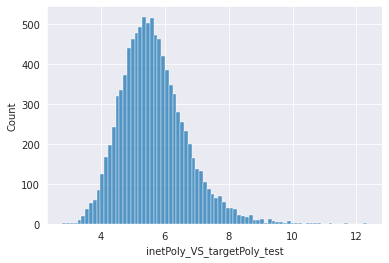

In [65]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

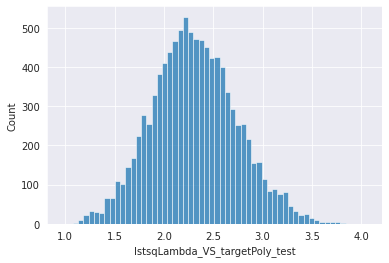

In [66]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'])


[(-30.0, 1.0)]

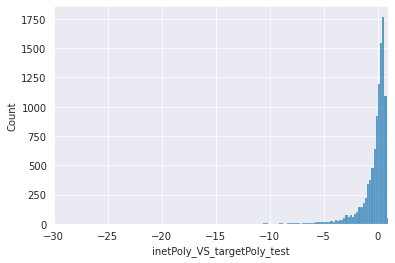

In [67]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

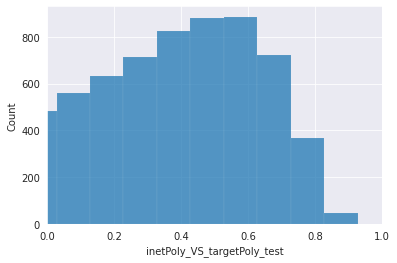

In [68]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

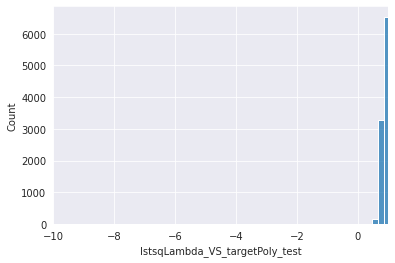

In [69]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

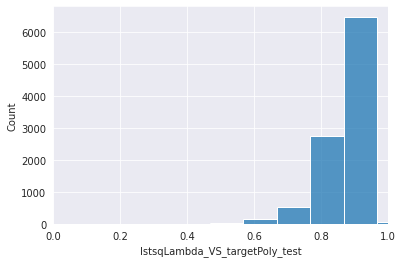

In [70]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

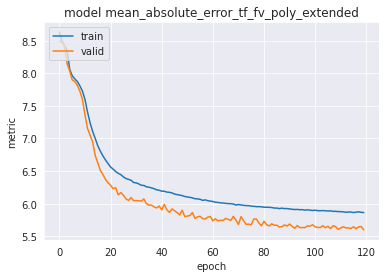

In [71]:
plt.plot(history[list(history.keys())[1]])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
plt.title('model ' + list(history.keys())[1])
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


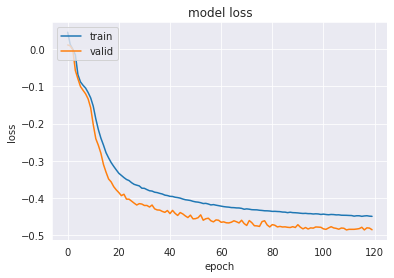

In [72]:
plt.plot(history['loss'])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

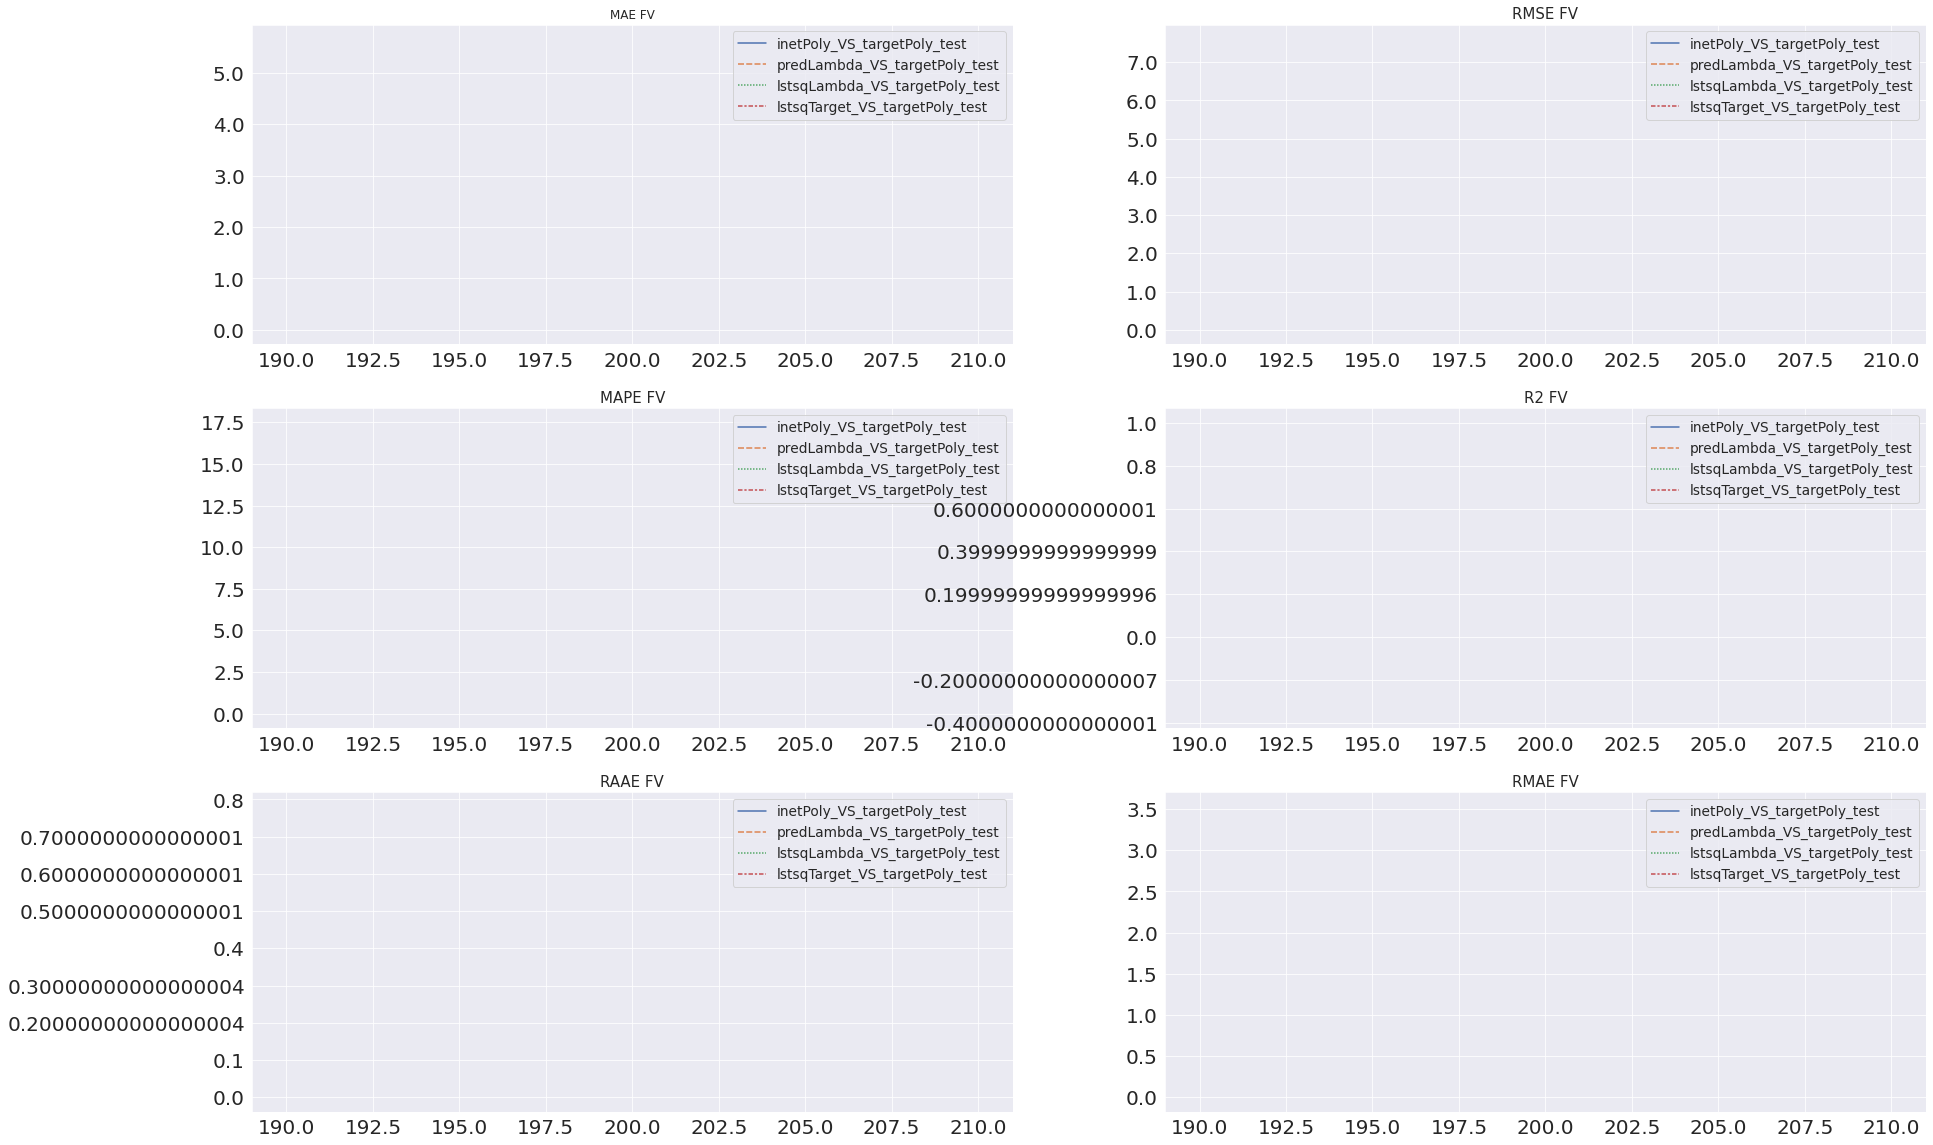

In [73]:
#Generate plot TEST PRED
plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

if samples_list == None:
    x_axis_steps = [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]
    x_max = epochs_lambda
else:
    x_axis_steps = samples_list
    x_max = samples_list[-1]
    
if evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    for index, metric in enumerate(plot_metric_list):

        inetPoly_VS_targetPoly_test = []
        #inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        #inetPoly_VS_lstsqLambda_test = []
        #lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_targetPoly_test.append(scores[metric].loc['inetPoly_VS_targetPoly_test'])
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])
            lstsqLambda_VS_targetPoly_test.append(scores[metric].loc['lstsqLambda_VS_targetPoly_test'])     
            lstsqTarget_VS_targetPoly_test.append(scores[metric].loc['lstsqTarget_VS_targetPoly_test'])
        
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_targetPoly_test, predLambda_VS_targetPoly_test, lstsqLambda_VS_targetPoly_test, lstsqTarget_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test'])

        ax[index//2, index%2].set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)        
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_REAL_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else:
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
else:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    for index, metric in enumerate(plot_metric_list):

        #inetPoly_VS_targetPoly_test = []
        inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        inetPoly_VS_lstsqLambda_test = []
        lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        #lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        #lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_lstsqLambda_test.append(scores[metric].loc['inetPoly_VS_lstsqLambda_test'])
            inetPoly_VS_predLambda_test.append(scores[metric].loc['inetPoly_VS_predLambda_test'])
            lstsqLambda_VS_predLambda_test.append(scores[metric].loc['lstsqLambda_VS_predLambda_test'])     
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])     
            
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_predLambda_test, inetPoly_VS_lstsqLambda_test, lstsqLambda_VS_predLambda_test, predLambda_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test'])

        ax[index//2, index%2].set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)  

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else: 
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


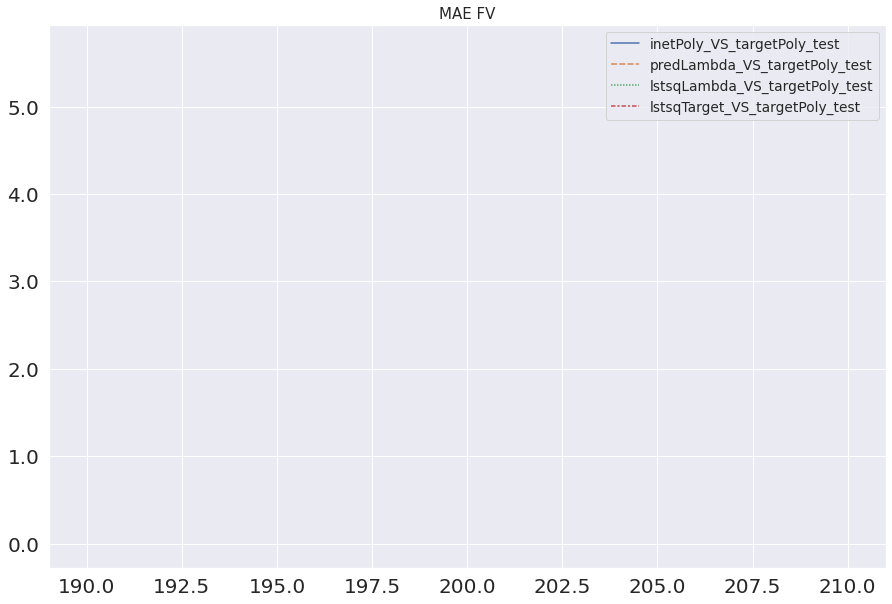

In [74]:
#Generate plot TEST PRED
plot_metric_list = ['MAE FV']

if samples_list == None:
    x_axis_steps = [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]
    x_max = epochs_lambda
else:
    x_axis_steps = samples_list
    x_max = samples_list[-1]
    
if evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        inetPoly_VS_targetPoly_test = []
        #inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        #inetPoly_VS_lstsqLambda_test = []
        #lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_targetPoly_test.append(scores[metric].loc['inetPoly_VS_targetPoly_test'])
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])
            lstsqLambda_VS_targetPoly_test.append(scores[metric].loc['lstsqLambda_VS_targetPoly_test'])     
            lstsqTarget_VS_targetPoly_test.append(scores[metric].loc['lstsqTarget_VS_targetPoly_test'])
        
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_targetPoly_test, predLambda_VS_targetPoly_test, lstsqLambda_VS_targetPoly_test, lstsqTarget_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_REAL_' + metric + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else:
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
else:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        #inetPoly_VS_targetPoly_test = []
        inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        inetPoly_VS_lstsqLambda_test = []
        lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        #lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        #lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_lstsqLambda_test.append(scores[metric].loc['inetPoly_VS_lstsqLambda_test'])
            inetPoly_VS_predLambda_test.append(scores[metric].loc['inetPoly_VS_predLambda_test'])
            lstsqLambda_VS_predLambda_test.append(scores[metric].loc['lstsqLambda_VS_predLambda_test'])     
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])     
            
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_predLambda_test, inetPoly_VS_lstsqLambda_test, lstsqLambda_VS_predLambda_test, predLambda_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else: 
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


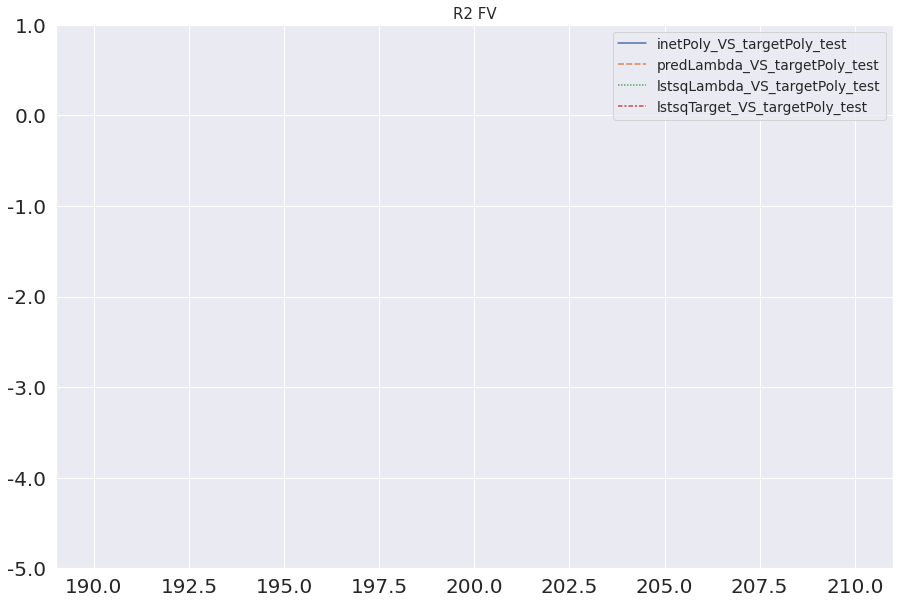

In [75]:
#Generate plot TEST PRED
plot_metric_list = ['R2 FV']

if samples_list == None:
    x_axis_steps = [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]
    x_max = epochs_lambda
else:
    x_axis_steps = samples_list
    x_max = samples_list[-1]
    
if evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        inetPoly_VS_targetPoly_test = []
        #inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        #inetPoly_VS_lstsqLambda_test = []
        #lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_targetPoly_test.append(scores[metric].loc['inetPoly_VS_targetPoly_test'])
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])
            lstsqLambda_VS_targetPoly_test.append(scores[metric].loc['lstsqLambda_VS_targetPoly_test'])     
            lstsqTarget_VS_targetPoly_test.append(scores[metric].loc['lstsqTarget_VS_targetPoly_test'])
        
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_targetPoly_test, predLambda_VS_targetPoly_test, lstsqLambda_VS_targetPoly_test, lstsqTarget_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set(ylim=(-5, 1))
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_REAL_' + metric + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else:
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
else:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        #inetPoly_VS_targetPoly_test = []
        inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        inetPoly_VS_lstsqLambda_test = []
        lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        #lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        #lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_lstsqLambda_test.append(scores[metric].loc['inetPoly_VS_lstsqLambda_test'])
            inetPoly_VS_predLambda_test.append(scores[metric].loc['inetPoly_VS_predLambda_test'])
            lstsqLambda_VS_predLambda_test.append(scores[metric].loc['lstsqLambda_VS_predLambda_test'])     
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])     
            
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_predLambda_test, inetPoly_VS_lstsqLambda_test, lstsqLambda_VS_predLambda_test, predLambda_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set(ylim=(-5, 1))
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else: 
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()


#### Generate and Analyze Predictions for Random Function

In [76]:
rand_index = 42

lambda_model_preds = function_values_test_list[-1][0][rand_index].ravel()
real_poly_fvs = function_values_test_list[-1][1][rand_index]
lstsq_lambda_preds_poly = function_values_test_list[-1][2][rand_index]
lstsq_target_poly = function_values_test_list[-1][3][rand_index]
inet_poly_fvs = function_values_test_list[-1][4][rand_index]

    
x_vars = ['x' + str(i) for i in range(1, n+1)]

columns = x_vars.copy()
columns.append('FVs')

columns_single = x_vars.copy()

eval_size_plot = inet_poly_fvs.shape[0]
vars_plot = lambda_net_test_dataset_list[-1].test_data_list[rand_index]

    
if evaluate_with_real_function:
    columns_single.extend(['Lambda Model Preds', 'Target Poly FVs', 'LSTSQ Target Poly FVs', 'I-Net Poly FVs'])
    plot_data_single = pd.DataFrame(data=np.column_stack([vars_plot, lambda_model_preds, real_poly_fvs, lstsq_target_poly, inet_poly_fvs]), columns=columns_single)
    preds_plot_all = np.vstack([lambda_model_preds, real_poly_fvs, lstsq_target_poly, inet_poly_fvs]).ravel()
    vars_plot_all_preds = np.vstack([vars_plot for i in range(len(columns_single[n:]))])
    
    lambda_model_preds_str = np.array(['Lambda Model Preds' for i in range(eval_size_plot)])
    real_poly_fvs_str = np.array(['Target Poly FVs' for i in range(eval_size_plot)])
    lstsq_target_poly_str = np.array(['LSTSQ Target Poly FVs' for i in range(eval_size_plot)])
    inet_poly_fvs_str = np.array(['I-Net Poly FVs' for i in range(eval_size_plot)])
    
    identifier = np.concatenate([lambda_model_preds_str, real_poly_fvs_str, lstsq_target_poly_str, inet_poly_fvs_str])
else:
    columns_single.extend(['Lambda Model Preds', 'Target Poly FVs', 'LSTSQ Lambda Poly FVs', 'I-Net Poly FVs'])
    plot_data_single = pd.DataFrame(data=np.column_stack([vars_plot, lambda_model_preds, real_poly_fvs, lstsq_lambda_preds_poly, inet_poly_fvs]), columns=columns_single)
    preds_plot_all = np.vstack([lambda_model_preds, real_poly_fvs, lstsq_lambda_preds_poly, inet_poly_fvs]).ravel()
    vars_plot_all_preds = np.vstack([vars_plot for i in range(len(columns_single[n:]))])
    
    lambda_model_preds_str = np.array(['Lambda Model Preds' for i in range(eval_size_plot)])
    real_poly_fvs_str = np.array(['Target Poly FVs' for i in range(eval_size_plot)])
    lstsq_lambda_preds_poly_str = np.array(['LSTSQ Lambda Poly FVs' for i in range(eval_size_plot)])
    inet_poly_fvs_str = np.array(['I-Net Poly FVs' for i in range(eval_size_plot)])
    
    identifier = np.concatenate([lambda_model_preds_str, real_poly_fvs_str, lstsq_lambda_preds_poly_str, inet_poly_fvs_str])

plot_data = pd.DataFrame(data=np.column_stack([vars_plot_all_preds, preds_plot_all]), columns=columns)
plot_data['Identifier'] = identifier



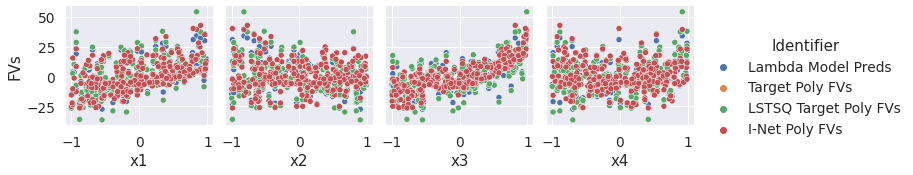

In [77]:
pp1 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  y_vars=['FVs'],
                  x_vars=x_vars)

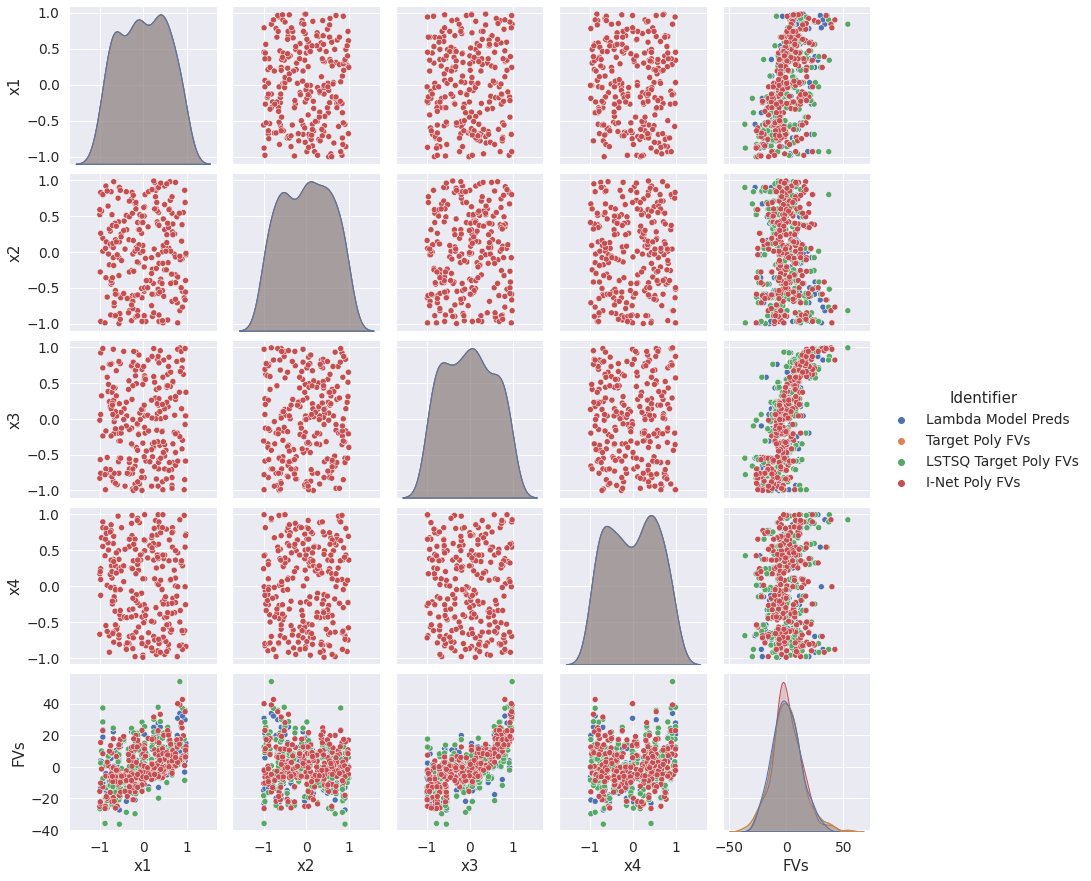

In [78]:
pp2 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  #y_vars=['FVs'],
                  #x_vars=x_vars
                 )

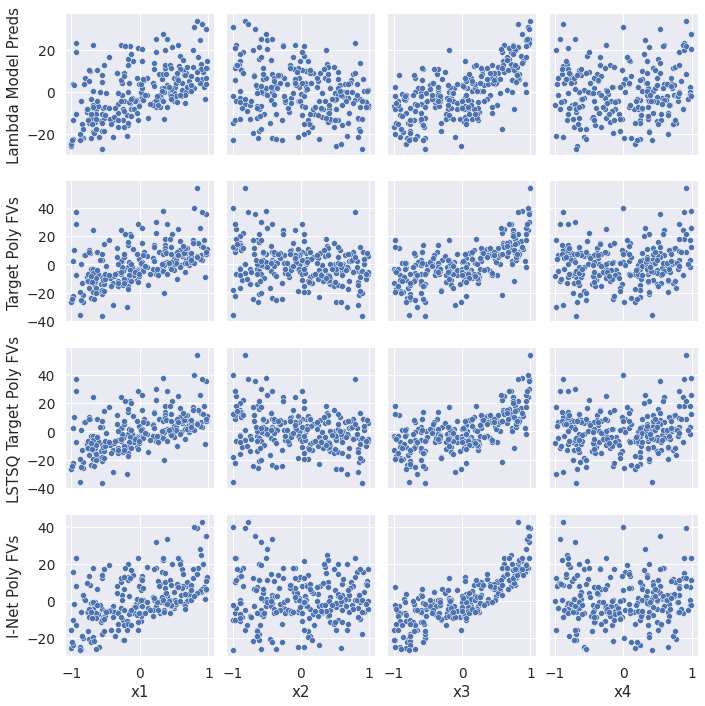

In [79]:
pp3 = sns.pairplot(data=plot_data_single,
                  #kind='reg',
                  y_vars=columns_single[n:],
                  x_vars=x_vars)

In [80]:
if evaluate_with_real_function:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_REAL_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')
else:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_PRED_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')    
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

# BENCHMARK (RANDOM GUESS) EVALUATION

In [81]:
list_of_random_polynomials = []
for i in range(len(lambda_net_test_dataset_list[-1])):
    random_polynomial = list(random_product([i*a_step for i in range(int(a_min*10**int(-np.log10(a_step))), int(a_max*10**int(-np.log10(a_step))))], repeat=nCr(n+d, d)))
    list_of_random_polynomials.append(random_polynomial)

In [82]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list)

In [83]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 6.6694


In [84]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 14.4167


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [85]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [86]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 10.2441


In [87]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True

